# IDP MD Simulation Analysis Protocol:
------
Developed for analysis of wildtype simulation 

## Notes:
#### Preprocessing
- Must specify protein length and window sizes
- Data is normalized to 0-1
---
#### Feature Enrichment
- No enrichment or filtering
---
#### Autoencoder Tuning
- No Tuning - Predetermined structure
---
#### Autoencoder Training
- Default Structure, Default Data
- 8, 7, 6, 5, 4 Layer Models
- 4x, 2x, 1x, 0.5x, 0.25x Node Models
- All run with [BS:256 LR:1x10^-5]  OR   [BS:128 LR:1x10^-6] 
---
#### Clustering
- Agglomerative Co-Clustering

In [ ]:
import os
import re
import sys
import glob
import time
import json
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy.stats import mode
from kneed import KneeLocator
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from IPython.display import Image, display

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Activation, Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import Callback

# Visualize Loss/Val_Loss Graphs

### Batch Size: 256
### Learning Rate: 1x10^-5

# 8 Layer Model

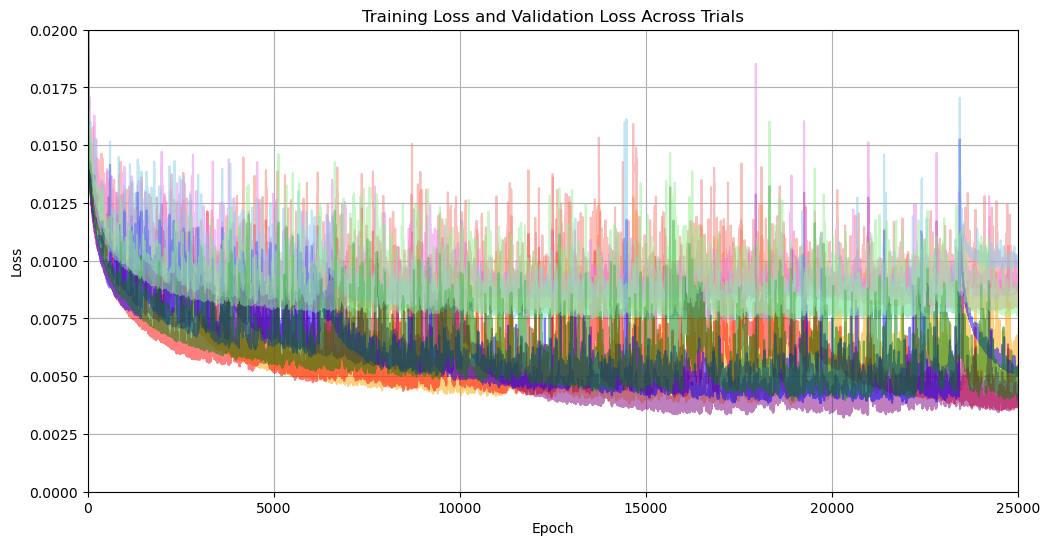

Trial 1:
  Minimum Loss: 0.003795 at Epoch 18893
  Minimum Validation Loss: 0.008306 at Epoch 5955
Trial 2:
  Minimum Loss: 0.003529 at Epoch 24501
  Minimum Validation Loss: 0.007762 at Epoch 11521
Trial 3:
  Minimum Loss: 0.003208 at Epoch 20310
  Minimum Validation Loss: 0.008042 at Epoch 9567
Trial 4:
  Minimum Loss: 0.003835 at Epoch 19692
  Minimum Validation Loss: 0.007395 at Epoch 16922
Trial 5:
  Minimum Loss: 0.003952 at Epoch 18940
  Minimum Validation Loss: 0.007391 at Epoch 20348
Average Difference Between Loss and Validation Loss (Epochs > 1000): -0.003289
Variability of Loss Across Trials (Epochs > 1000): 0.000830
Variability of Validation Loss Across Trials (Epochs > 1000): 0.000612


In [22]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the base folder where training loss data is stored
base_folder = 'AE_Grid_BS_256_LR_5/8_Layer_AE_Default_Data'
trial_colors = ['orange', 'red', 'purple', 'blue', 'green']
val_colors = ['lightcoral', 'salmon', 'violet', 'skyblue', 'lightgreen']

# Initialize lists to store global data for statistics
global_loss = []
global_val_loss = []

# Loop through each trial to collect and plot data
plt.figure(figsize=(12, 6))
for trial in range(1, 6):
    loss_data_folder = os.path.join(base_folder, f'AE_Training_{trial}/AE_Training_Loss_Data')
    all_loss = []
    all_val_loss = []
    
    # Load all training loss data for the current trial
    for counts in range(25):  # Adjust range if the number of files per trial differs
        history_file_path = os.path.join(loss_data_folder, f"{counts}_Autoencoder_Training_History.pkl")
        if os.path.exists(history_file_path):
            history = pd.read_pickle(history_file_path)
            all_loss.extend(history['loss'].tolist())
            all_val_loss.extend(history['val_loss'].tolist())
        else:
            print(f"Warning: Missing file for count {counts} in trial {trial}")
    
    # Ensure epoch indices are properly aligned with the number of epochs
    epochs = list(range(len(all_loss)))
    
    # Append to global lists for statistics
    global_loss.append(all_loss)
    global_val_loss.append(all_val_loss)
    
    # Plot loss and validation loss for the current trial
    plt.plot(epochs, all_loss, label=f'Trial {trial} Loss', color=trial_colors[trial - 1], alpha=0.5)
    plt.plot(epochs, all_val_loss, label=f'Trial {trial} Validation Loss', color=val_colors[trial - 1], alpha=0.5)

# Add plot details
plt.title('Training Loss and Validation Loss: 8 Layer AE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0, 25000)
plt.ylim(0, 0.02)
# plt.legend()
plt.grid()
plt.show()

# Calculate and print minimum loss and validation loss for each trial
for trial in range(5):
    trial_loss = np.array(global_loss[trial])
    trial_val_loss = np.array(global_val_loss[trial])
    
    # Find minimum loss and validation loss for the trial
    min_loss = np.min(trial_loss)
    min_loss_epoch = np.argmin(trial_loss)
    min_val_loss = np.min(trial_val_loss)
    min_val_loss_epoch = np.argmin(trial_val_loss)
    
    print(f"Trial {trial + 1}:")
    print(f"  Minimum Loss: {min_loss:.6f} at Epoch {min_loss_epoch}")
    print(f"  Minimum Validation Loss: {min_val_loss:.6f} at Epoch {min_val_loss_epoch}")

# Calculate average difference between loss and validation loss (ignoring first 1000 epochs)
avg_loss_val_loss_diff = np.mean([
    np.mean(np.array(global_loss[i][1000:]) - np.array(global_val_loss[i][1000:])) 
    for i in range(5)
])
print(f"Average Difference Between Loss and Validation Loss (Epochs > 1000): {avg_loss_val_loss_diff:.6f}")

# Calculate variability of loss and validation loss across trials (ignoring first 1000 epochs)
loss_variability = np.mean([
    np.std([global_loss[i][epoch] for i in range(5)]) 
    for epoch in range(1000, len(global_loss[0]))
])
val_loss_variability = np.mean([
    np.std([global_val_loss[i][epoch] for i in range(5)]) 
    for epoch in range(1000, len(global_val_loss[0]))
])

print(f"Variability of Loss Across Trials (Epochs > 1000): {loss_variability:.6f}")
print(f"Variability of Validation Loss Across Trials (Epochs > 1000): {val_loss_variability:.6f}")


# 7 Layer Model

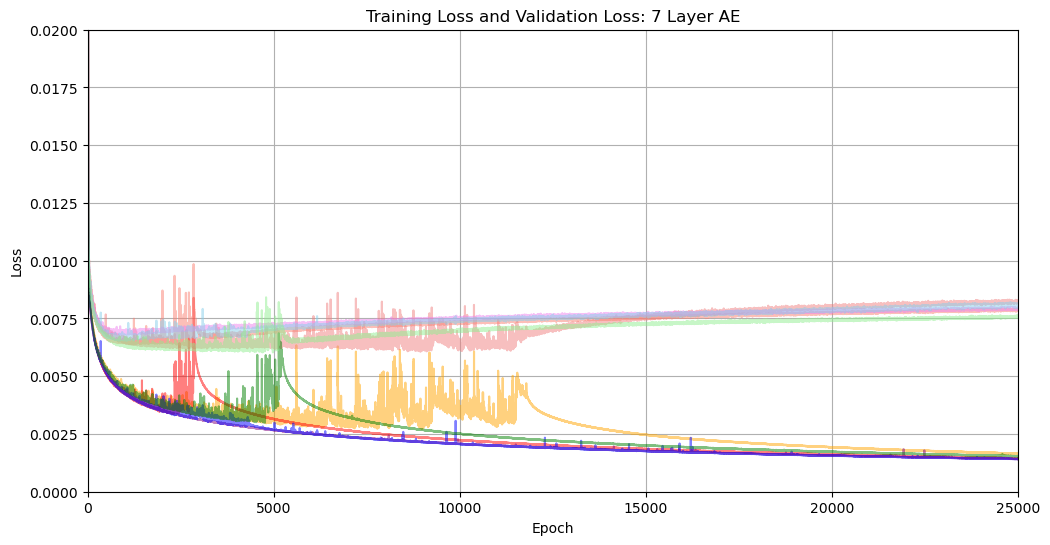

Trial 1:
  Minimum Loss: 0.001644 at Epoch 24967
  Minimum Validation Loss: 0.006068 at Epoch 8942
Trial 2:
  Minimum Loss: 0.001444 at Epoch 24916
  Minimum Validation Loss: 0.006289 at Epoch 2690
Trial 3:
  Minimum Loss: 0.001409 at Epoch 24983
  Minimum Validation Loss: 0.006801 at Epoch 1023
Trial 4:
  Minimum Loss: 0.001410 at Epoch 24997
  Minimum Validation Loss: 0.006526 at Epoch 1040
Trial 5:
  Minimum Loss: 0.001534 at Epoch 24976
  Minimum Validation Loss: 0.006032 at Epoch 4969
Average Difference Between Loss and Validation Loss (Epochs > 1000): -0.004994
Variability of Loss Across Trials (Epochs > 1000): 0.000322
Variability of Validation Loss Across Trials (Epochs > 1000): 0.000260


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the base folder where training loss data is stored
base_folder = 'AE_Grid_XGB_Filtered/AE_Grid_BS_256_LR_5_Filtered/7_Layer_AE_Default_Data'
trial_colors = ['orange', 'red', 'purple', 'blue', 'green']
val_colors = ['lightcoral', 'salmon', 'violet', 'skyblue', 'lightgreen']

# Initialize lists to store global data for statistics
global_loss = []
global_val_loss = []

# Loop through each trial to collect and plot data
plt.figure(figsize=(12, 6))
for trial in range(1, 6):
    loss_data_folder = os.path.join(base_folder, f'AE_Training_{trial}/AE_Training_Loss_Data')
    all_loss = []
    all_val_loss = []
    
    # Load all training loss data for the current trial
    for counts in range(25):  # Adjust range if the number of files per trial differs
        history_file_path = os.path.join(loss_data_folder, f"{counts}_Autoencoder_Training_History.pkl")
        if os.path.exists(history_file_path):
            history = pd.read_pickle(history_file_path)
            all_loss.extend(history['loss'].tolist())
            all_val_loss.extend(history['val_loss'].tolist())
        else:
            print(f"Warning: Missing file for count {counts} in trial {trial}")
    
    # Ensure epoch indices are properly aligned with the number of epochs
    epochs = list(range(len(all_loss)))
    
    # Append to global lists for statistics
    global_loss.append(all_loss)
    global_val_loss.append(all_val_loss)
    
    # Plot loss and validation loss for the current trial
    plt.plot(epochs, all_loss, label=f'Trial {trial} Loss', color=trial_colors[trial - 1], alpha=0.5)
    plt.plot(epochs, all_val_loss, label=f'Trial {trial} Validation Loss', color=val_colors[trial - 1], alpha=0.5)

# Add plot details
plt.title('Training Loss and Validation Loss: 7 Layer AE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0, 25000)
plt.ylim(0, 0.02)
# plt.legend()
plt.grid()
plt.show()

# Calculate and print minimum loss and validation loss for each trial
for trial in range(5):
    trial_loss = np.array(global_loss[trial])
    trial_val_loss = np.array(global_val_loss[trial])
    
    # Find minimum loss and validation loss for the trial
    min_loss = np.min(trial_loss)
    min_loss_epoch = np.argmin(trial_loss)
    min_val_loss = np.min(trial_val_loss)
    min_val_loss_epoch = np.argmin(trial_val_loss)
    
    print(f"Trial {trial + 1}:")
    print(f"  Minimum Loss: {min_loss:.6f} at Epoch {min_loss_epoch}")
    print(f"  Minimum Validation Loss: {min_val_loss:.6f} at Epoch {min_val_loss_epoch}")

# Calculate average difference between loss and validation loss (ignoring first 1000 epochs)
avg_loss_val_loss_diff = np.mean([
    np.mean(np.array(global_loss[i][1000:]) - np.array(global_val_loss[i][1000:])) 
    for i in range(5)
])
print(f"Average Difference Between Loss and Validation Loss (Epochs > 1000): {avg_loss_val_loss_diff:.6f}")

# Calculate variability of loss and validation loss across trials (ignoring first 1000 epochs)
loss_variability = np.mean([
    np.std([global_loss[i][epoch] for i in range(5)]) 
    for epoch in range(1000, len(global_loss[0]))
])
val_loss_variability = np.mean([
    np.std([global_val_loss[i][epoch] for i in range(5)]) 
    for epoch in range(1000, len(global_val_loss[0]))
])

print(f"Variability of Loss Across Trials (Epochs > 1000): {loss_variability:.6f}")
print(f"Variability of Validation Loss Across Trials (Epochs > 1000): {val_loss_variability:.6f}")


# 6 Layer Model (Default)

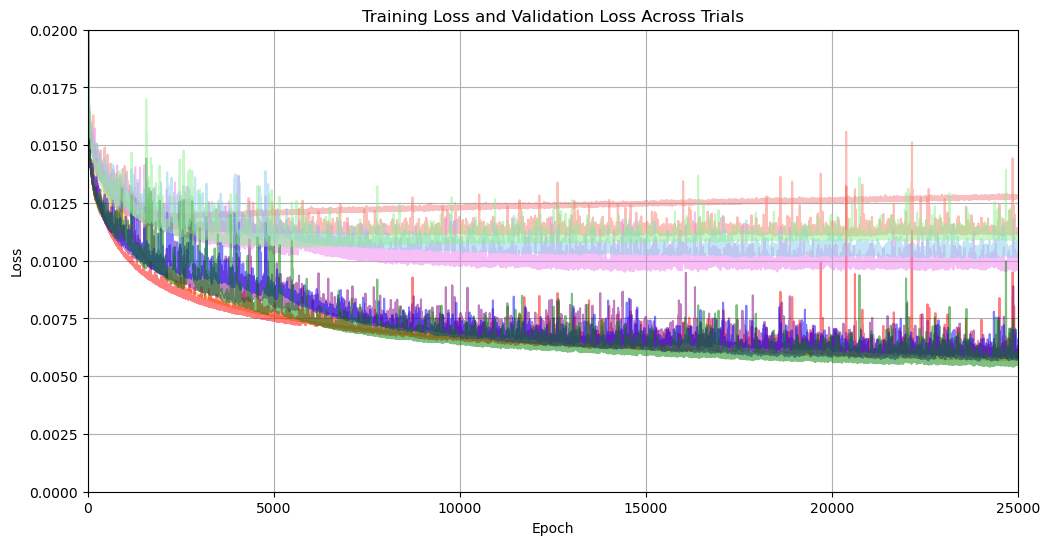

Trial 1:
  Minimum Loss: 0.005704 at Epoch 24993
  Minimum Validation Loss: 0.011853 at Epoch 2751
Trial 2:
  Minimum Loss: 0.005780 at Epoch 24411
  Minimum Validation Loss: 0.011060 at Epoch 20490
Trial 3:
  Minimum Loss: 0.005762 at Epoch 24714
  Minimum Validation Loss: 0.009518 at Epoch 14416
Trial 4:
  Minimum Loss: 0.005666 at Epoch 23932
  Minimum Validation Loss: 0.010115 at Epoch 23802
Trial 5:
  Minimum Loss: 0.005414 at Epoch 24866
  Minimum Validation Loss: 0.010583 at Epoch 5868
Average Difference Between Loss and Validation Loss (Epochs > 1000): -0.004230
Variability of Loss Across Trials (Epochs > 1000): 0.000298
Variability of Validation Loss Across Trials (Epochs > 1000): 0.000762


In [24]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the base folder where training loss data is stored
base_folder = 'AE_Grid_BS_256_LR_5/Default_AE_Default_Data'
trial_colors = ['orange', 'red', 'purple', 'blue', 'green']
val_colors = ['lightcoral', 'salmon', 'violet', 'skyblue', 'lightgreen']

# Initialize lists to store global data for statistics
global_loss = []
global_val_loss = []

# Loop through each trial to collect and plot data
plt.figure(figsize=(12, 6))
for trial in range(1, 6):
    loss_data_folder = os.path.join(base_folder, f'AE_Training_{trial}/AE_Training_Loss_Data')
    all_loss = []
    all_val_loss = []
    
    # Load all training loss data for the current trial
    for counts in range(25):  # Adjust range if the number of files per trial differs
        history_file_path = os.path.join(loss_data_folder, f"{counts}_Autoencoder_Training_History.pkl")
        if os.path.exists(history_file_path):
            history = pd.read_pickle(history_file_path)
            all_loss.extend(history['loss'].tolist())
            all_val_loss.extend(history['val_loss'].tolist())
        else:
            print(f"Warning: Missing file for count {counts} in trial {trial}")
    
    # Ensure epoch indices are properly aligned with the number of epochs
    epochs = list(range(len(all_loss)))
    
    # Append to global lists for statistics
    global_loss.append(all_loss)
    global_val_loss.append(all_val_loss)
    
    # Plot loss and validation loss for the current trial
    plt.plot(epochs, all_loss, label=f'Trial {trial} Loss', color=trial_colors[trial - 1], alpha=0.5)
    plt.plot(epochs, all_val_loss, label=f'Trial {trial} Validation Loss', color=val_colors[trial - 1], alpha=0.5)

# Add plot details
plt.title('Training Loss and Validation Loss: 6 Layer AE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0, 25000)
plt.ylim(0, 0.02)
# plt.legend()
plt.grid()
plt.show()

# Calculate and print minimum loss and validation loss for each trial
for trial in range(5):
    trial_loss = np.array(global_loss[trial])
    trial_val_loss = np.array(global_val_loss[trial])
    
    # Find minimum loss and validation loss for the trial
    min_loss = np.min(trial_loss)
    min_loss_epoch = np.argmin(trial_loss)
    min_val_loss = np.min(trial_val_loss)
    min_val_loss_epoch = np.argmin(trial_val_loss)
    
    print(f"Trial {trial + 1}:")
    print(f"  Minimum Loss: {min_loss:.6f} at Epoch {min_loss_epoch}")
    print(f"  Minimum Validation Loss: {min_val_loss:.6f} at Epoch {min_val_loss_epoch}")

# Calculate average difference between loss and validation loss (ignoring first 1000 epochs)
avg_loss_val_loss_diff = np.mean([
    np.mean(np.array(global_loss[i][1000:]) - np.array(global_val_loss[i][1000:])) 
    for i in range(5)
])
print(f"Average Difference Between Loss and Validation Loss (Epochs > 1000): {avg_loss_val_loss_diff:.6f}")

# Calculate variability of loss and validation loss across trials (ignoring first 1000 epochs)
loss_variability = np.mean([
    np.std([global_loss[i][epoch] for i in range(5)]) 
    for epoch in range(1000, len(global_loss[0]))
])
val_loss_variability = np.mean([
    np.std([global_val_loss[i][epoch] for i in range(5)]) 
    for epoch in range(1000, len(global_val_loss[0]))
])

print(f"Variability of Loss Across Trials (Epochs > 1000): {loss_variability:.6f}")
print(f"Variability of Validation Loss Across Trials (Epochs > 1000): {val_loss_variability:.6f}")


# 5 Layer Model

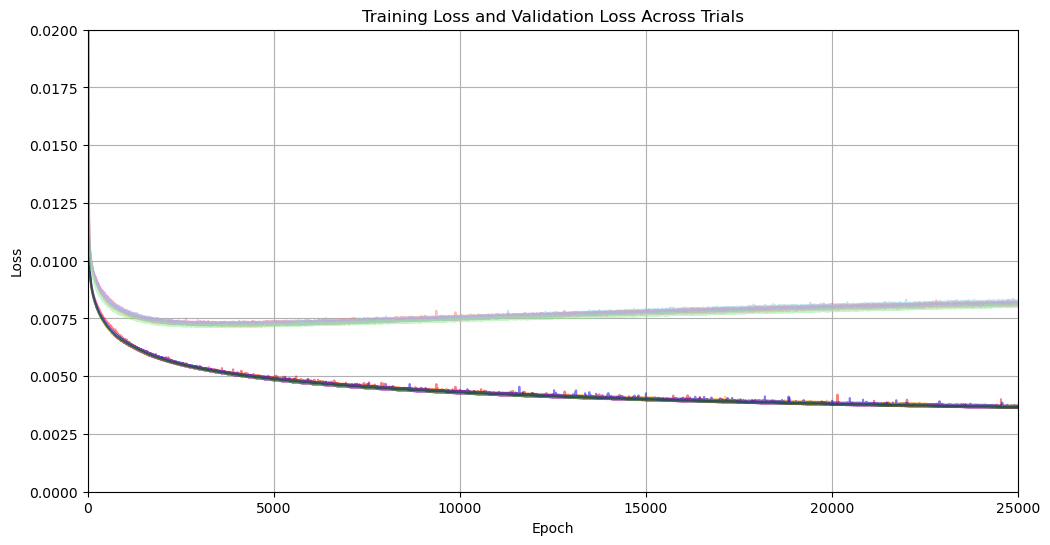

Trial 1:
  Minimum Loss: 0.003724 at Epoch 24880
  Minimum Validation Loss: 0.007191 at Epoch 3132
Trial 2:
  Minimum Loss: 0.003643 at Epoch 24991
  Minimum Validation Loss: 0.007161 at Epoch 3958
Trial 3:
  Minimum Loss: 0.003623 at Epoch 24964
  Minimum Validation Loss: 0.007178 at Epoch 4099
Trial 4:
  Minimum Loss: 0.003684 at Epoch 24919
  Minimum Validation Loss: 0.007178 at Epoch 3284
Trial 5:
  Minimum Loss: 0.003637 at Epoch 24944
  Minimum Validation Loss: 0.007115 at Epoch 3660
Average Difference Between Loss and Validation Loss (Epochs > 1000): -0.003351
Variability of Loss Across Trials (Epochs > 1000): 0.000035
Variability of Validation Loss Across Trials (Epochs > 1000): 0.000056


In [25]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the base folder where training loss data is stored
base_folder = 'AE_Grid_BS_256_LR_5/5_Layer_AE_Default_Data'
trial_colors = ['orange', 'red', 'purple', 'blue', 'green']
val_colors = ['lightcoral', 'salmon', 'violet', 'skyblue', 'lightgreen']

# Initialize lists to store global data for statistics
global_loss = []
global_val_loss = []

# Loop through each trial to collect and plot data
plt.figure(figsize=(12, 6))
for trial in range(1, 6):
    loss_data_folder = os.path.join(base_folder, f'AE_Training_{trial}/AE_Training_Loss_Data')
    all_loss = []
    all_val_loss = []
    
    # Load all training loss data for the current trial
    for counts in range(25):  # Adjust range if the number of files per trial differs
        history_file_path = os.path.join(loss_data_folder, f"{counts}_Autoencoder_Training_History.pkl")
        if os.path.exists(history_file_path):
            history = pd.read_pickle(history_file_path)
            all_loss.extend(history['loss'].tolist())
            all_val_loss.extend(history['val_loss'].tolist())
        else:
            print(f"Warning: Missing file for count {counts} in trial {trial}")
    
    # Ensure epoch indices are properly aligned with the number of epochs
    epochs = list(range(len(all_loss)))
    
    # Append to global lists for statistics
    global_loss.append(all_loss)
    global_val_loss.append(all_val_loss)
    
    # Plot loss and validation loss for the current trial
    plt.plot(epochs, all_loss, label=f'Trial {trial} Loss', color=trial_colors[trial - 1], alpha=0.5)
    plt.plot(epochs, all_val_loss, label=f'Trial {trial} Validation Loss', color=val_colors[trial - 1], alpha=0.5)

# Add plot details
plt.title('Training Loss and Validation Loss: 5 Layer AE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0, 25000)
plt.ylim(0, 0.02)
# plt.legend()
plt.grid()
plt.show()

# Calculate and print minimum loss and validation loss for each trial
for trial in range(5):
    trial_loss = np.array(global_loss[trial])
    trial_val_loss = np.array(global_val_loss[trial])
    
    # Find minimum loss and validation loss for the trial
    min_loss = np.min(trial_loss)
    min_loss_epoch = np.argmin(trial_loss)
    min_val_loss = np.min(trial_val_loss)
    min_val_loss_epoch = np.argmin(trial_val_loss)
    
    print(f"Trial {trial + 1}:")
    print(f"  Minimum Loss: {min_loss:.6f} at Epoch {min_loss_epoch}")
    print(f"  Minimum Validation Loss: {min_val_loss:.6f} at Epoch {min_val_loss_epoch}")

# Calculate average difference between loss and validation loss (ignoring first 1000 epochs)
avg_loss_val_loss_diff = np.mean([
    np.mean(np.array(global_loss[i][1000:]) - np.array(global_val_loss[i][1000:])) 
    for i in range(5)
])
print(f"Average Difference Between Loss and Validation Loss (Epochs > 1000): {avg_loss_val_loss_diff:.6f}")

# Calculate variability of loss and validation loss across trials (ignoring first 1000 epochs)
loss_variability = np.mean([
    np.std([global_loss[i][epoch] for i in range(5)]) 
    for epoch in range(1000, len(global_loss[0]))
])
val_loss_variability = np.mean([
    np.std([global_val_loss[i][epoch] for i in range(5)]) 
    for epoch in range(1000, len(global_val_loss[0]))
])

print(f"Variability of Loss Across Trials (Epochs > 1000): {loss_variability:.6f}")
print(f"Variability of Validation Loss Across Trials (Epochs > 1000): {val_loss_variability:.6f}")


# 4 Layer Model

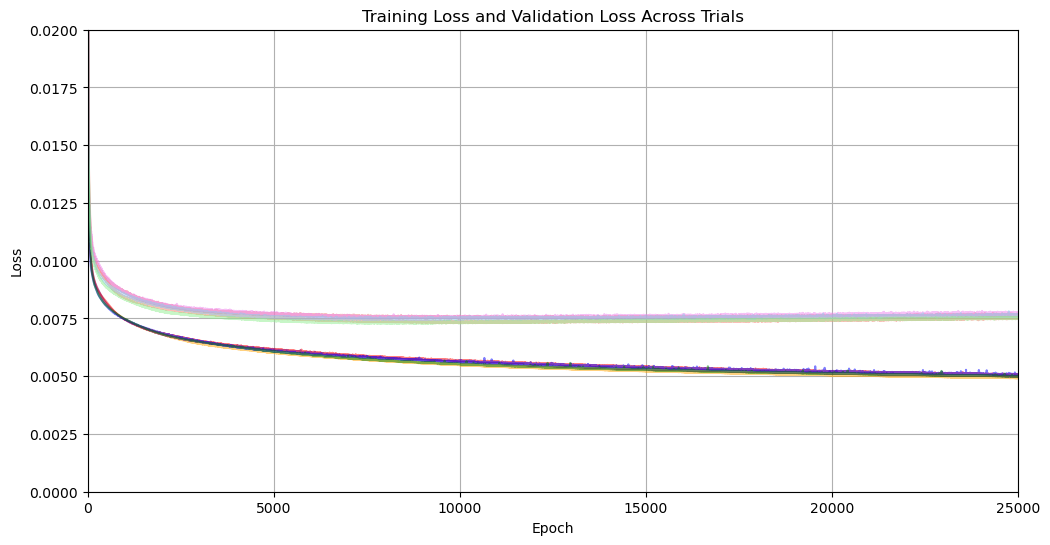

Trial 1:
  Minimum Loss: 0.004914 at Epoch 24981
  Minimum Validation Loss: 0.007477 at Epoch 11389
Trial 2:
  Minimum Loss: 0.005071 at Epoch 24997
  Minimum Validation Loss: 0.007297 at Epoch 11144
Trial 3:
  Minimum Loss: 0.004992 at Epoch 24957
  Minimum Validation Loss: 0.007491 at Epoch 9485
Trial 4:
  Minimum Loss: 0.005069 at Epoch 24975
  Minimum Validation Loss: 0.007431 at Epoch 8859
Trial 5:
  Minimum Loss: 0.004991 at Epoch 24984
  Minimum Validation Loss: 0.007270 at Epoch 8040
Average Difference Between Loss and Validation Loss (Epochs > 1000): -0.001984
Variability of Loss Across Trials (Epochs > 1000): 0.000061
Variability of Validation Loss Across Trials (Epochs > 1000): 0.000095


In [26]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the base folder where training loss data is stored
base_folder = 'AE_Grid_BS_256_LR_5/4_Layer_AE_Default_Data'
trial_colors = ['orange', 'red', 'purple', 'blue', 'green']
val_colors = ['lightcoral', 'salmon', 'violet', 'skyblue', 'lightgreen']

# Initialize lists to store global data for statistics
global_loss = []
global_val_loss = []

# Loop through each trial to collect and plot data
plt.figure(figsize=(12, 6))
for trial in range(1, 6):
    loss_data_folder = os.path.join(base_folder, f'AE_Training_{trial}/AE_Training_Loss_Data')
    all_loss = []
    all_val_loss = []
    
    # Load all training loss data for the current trial
    for counts in range(25):  # Adjust range if the number of files per trial differs
        history_file_path = os.path.join(loss_data_folder, f"{counts}_Autoencoder_Training_History.pkl")
        if os.path.exists(history_file_path):
            history = pd.read_pickle(history_file_path)
            all_loss.extend(history['loss'].tolist())
            all_val_loss.extend(history['val_loss'].tolist())
        else:
            print(f"Warning: Missing file for count {counts} in trial {trial}")
    
    # Ensure epoch indices are properly aligned with the number of epochs
    epochs = list(range(len(all_loss)))
    
    # Append to global lists for statistics
    global_loss.append(all_loss)
    global_val_loss.append(all_val_loss)
    
    # Plot loss and validation loss for the current trial
    plt.plot(epochs, all_loss, label=f'Trial {trial} Loss', color=trial_colors[trial - 1], alpha=0.5)
    plt.plot(epochs, all_val_loss, label=f'Trial {trial} Validation Loss', color=val_colors[trial - 1], alpha=0.5)

# Add plot details
plt.title('Training Loss and Validation Loss: 4 Layer AE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0, 25000)
plt.ylim(0, 0.02)
# plt.legend()
plt.grid()
plt.show()

# Calculate and print minimum loss and validation loss for each trial
for trial in range(5):
    trial_loss = np.array(global_loss[trial])
    trial_val_loss = np.array(global_val_loss[trial])
    
    # Find minimum loss and validation loss for the trial
    min_loss = np.min(trial_loss)
    min_loss_epoch = np.argmin(trial_loss)
    min_val_loss = np.min(trial_val_loss)
    min_val_loss_epoch = np.argmin(trial_val_loss)
    
    print(f"Trial {trial + 1}:")
    print(f"  Minimum Loss: {min_loss:.6f} at Epoch {min_loss_epoch}")
    print(f"  Minimum Validation Loss: {min_val_loss:.6f} at Epoch {min_val_loss_epoch}")

# Calculate average difference between loss and validation loss (ignoring first 1000 epochs)
avg_loss_val_loss_diff = np.mean([
    np.mean(np.array(global_loss[i][1000:]) - np.array(global_val_loss[i][1000:])) 
    for i in range(5)
])
print(f"Average Difference Between Loss and Validation Loss (Epochs > 1000): {avg_loss_val_loss_diff:.6f}")

# Calculate variability of loss and validation loss across trials (ignoring first 1000 epochs)
loss_variability = np.mean([
    np.std([global_loss[i][epoch] for i in range(5)]) 
    for epoch in range(1000, len(global_loss[0]))
])
val_loss_variability = np.mean([
    np.std([global_val_loss[i][epoch] for i in range(5)]) 
    for epoch in range(1000, len(global_val_loss[0]))
])

print(f"Variability of Loss Across Trials (Epochs > 1000): {loss_variability:.6f}")
print(f"Variability of Validation Loss Across Trials (Epochs > 1000): {val_loss_variability:.6f}")


# 4x Node Model

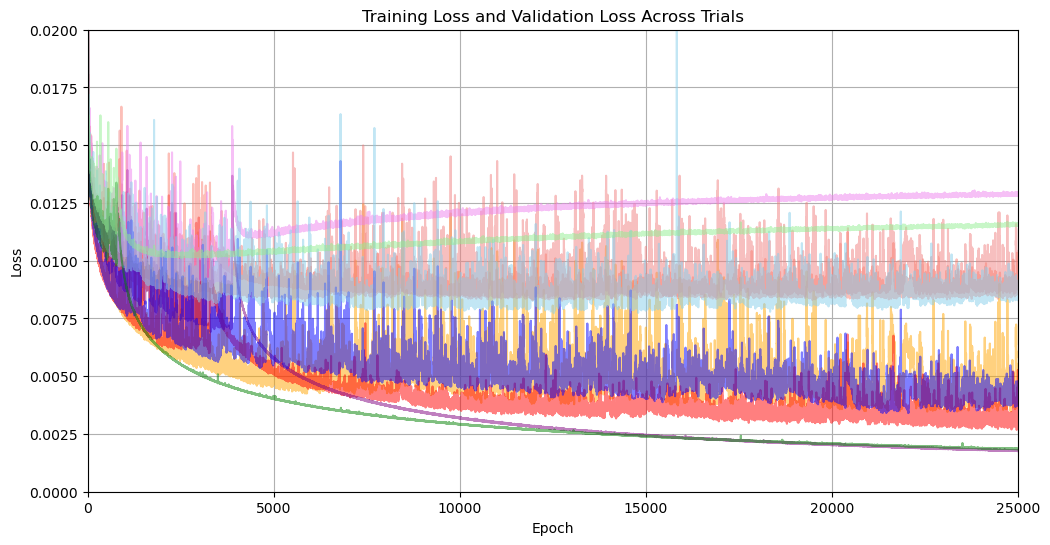

Trial 1:
  Minimum Loss: 0.003452 at Epoch 23102
  Minimum Validation Loss: 0.008251 at Epoch 5834
Trial 2:
  Minimum Loss: 0.002674 at Epoch 24964
  Minimum Validation Loss: 0.008268 at Epoch 12742
Trial 3:
  Minimum Loss: 0.001753 at Epoch 24998
  Minimum Validation Loss: 0.008854 at Epoch 3291
Trial 4:
  Minimum Loss: 0.003405 at Epoch 22053
  Minimum Validation Loss: 0.007732 at Epoch 12517
Trial 5:
  Minimum Loss: 0.001840 at Epoch 24940
  Minimum Validation Loss: 0.010135 at Epoch 2507
Average Difference Between Loss and Validation Loss (Epochs > 1000): -0.005715
Variability of Loss Across Trials (Epochs > 1000): 0.001067
Variability of Validation Loss Across Trials (Epochs > 1000): 0.001397


In [27]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the base folder where training loss data is stored
base_folder = 'AE_Grid_BS_256_LR_5/4x_Nodes_AE_Default_Data'
trial_colors = ['orange', 'red', 'purple', 'blue', 'green']
val_colors = ['lightcoral', 'salmon', 'violet', 'skyblue', 'lightgreen']

# Initialize lists to store global data for statistics
global_loss = []
global_val_loss = []

# Loop through each trial to collect and plot data
plt.figure(figsize=(12, 6))
for trial in range(1, 6):
    loss_data_folder = os.path.join(base_folder, f'AE_Training_{trial}/AE_Training_Loss_Data')
    all_loss = []
    all_val_loss = []
    
    # Load all training loss data for the current trial
    for counts in range(25):  # Adjust range if the number of files per trial differs
        history_file_path = os.path.join(loss_data_folder, f"{counts}_Autoencoder_Training_History.pkl")
        if os.path.exists(history_file_path):
            history = pd.read_pickle(history_file_path)
            all_loss.extend(history['loss'].tolist())
            all_val_loss.extend(history['val_loss'].tolist())
        else:
            print(f"Warning: Missing file for count {counts} in trial {trial}")
    
    # Ensure epoch indices are properly aligned with the number of epochs
    epochs = list(range(len(all_loss)))
    
    # Append to global lists for statistics
    global_loss.append(all_loss)
    global_val_loss.append(all_val_loss)
    
    # Plot loss and validation loss for the current trial
    plt.plot(epochs, all_loss, label=f'Trial {trial} Loss', color=trial_colors[trial - 1], alpha=0.5)
    plt.plot(epochs, all_val_loss, label=f'Trial {trial} Validation Loss', color=val_colors[trial - 1], alpha=0.5)

# Add plot details
plt.title('Training Loss and Validation Loss: 6 Layer, 4x Nodes AE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0, 25000)
plt.ylim(0, 0.02)
# plt.legend()
plt.grid()
plt.show()

# Calculate and print minimum loss and validation loss for each trial
for trial in range(5):
    trial_loss = np.array(global_loss[trial])
    trial_val_loss = np.array(global_val_loss[trial])
    
    # Find minimum loss and validation loss for the trial
    min_loss = np.min(trial_loss)
    min_loss_epoch = np.argmin(trial_loss)
    min_val_loss = np.min(trial_val_loss)
    min_val_loss_epoch = np.argmin(trial_val_loss)
    
    print(f"Trial {trial + 1}:")
    print(f"  Minimum Loss: {min_loss:.6f} at Epoch {min_loss_epoch}")
    print(f"  Minimum Validation Loss: {min_val_loss:.6f} at Epoch {min_val_loss_epoch}")

# Calculate average difference between loss and validation loss (ignoring first 1000 epochs)
avg_loss_val_loss_diff = np.mean([
    np.mean(np.array(global_loss[i][1000:]) - np.array(global_val_loss[i][1000:])) 
    for i in range(5)
])
print(f"Average Difference Between Loss and Validation Loss (Epochs > 1000): {avg_loss_val_loss_diff:.6f}")

# Calculate variability of loss and validation loss across trials (ignoring first 1000 epochs)
loss_variability = np.mean([
    np.std([global_loss[i][epoch] for i in range(5)]) 
    for epoch in range(1000, len(global_loss[0]))
])
val_loss_variability = np.mean([
    np.std([global_val_loss[i][epoch] for i in range(5)]) 
    for epoch in range(1000, len(global_val_loss[0]))
])

print(f"Variability of Loss Across Trials (Epochs > 1000): {loss_variability:.6f}")
print(f"Variability of Validation Loss Across Trials (Epochs > 1000): {val_loss_variability:.6f}")


# 2x Node Model

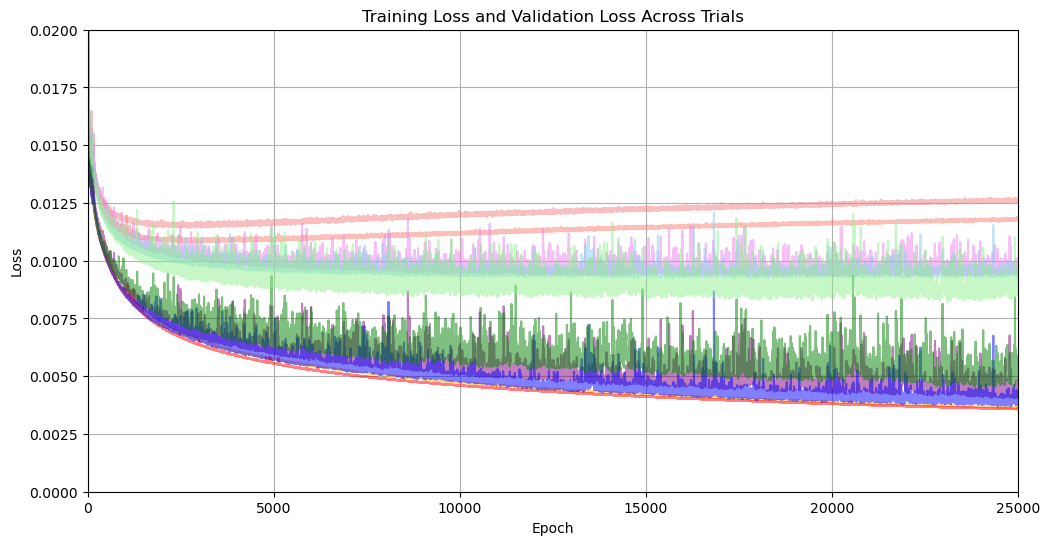

Trial 1:
  Minimum Loss: 0.003633 at Epoch 24982
  Minimum Validation Loss: 0.011428 at Epoch 2730
Trial 2:
  Minimum Loss: 0.003567 at Epoch 24978
  Minimum Validation Loss: 0.010794 at Epoch 3276
Trial 3:
  Minimum Loss: 0.004054 at Epoch 24911
  Minimum Validation Loss: 0.009288 at Epoch 22011
Trial 4:
  Minimum Loss: 0.003716 at Epoch 24816
  Minimum Validation Loss: 0.009234 at Epoch 15724
Trial 5:
  Minimum Loss: 0.004474 at Epoch 23982
  Minimum Validation Loss: 0.008205 at Epoch 23104
Average Difference Between Loss and Validation Loss (Epochs > 1000): -0.005240
Variability of Loss Across Trials (Epochs > 1000): 0.000520
Variability of Validation Loss Across Trials (Epochs > 1000): 0.001153


In [28]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the base folder where training loss data is stored
base_folder = 'AE_Grid_BS_256_LR_5/2x_Nodes_AE_Default_Data'
trial_colors = ['orange', 'red', 'purple', 'blue', 'green']
val_colors = ['lightcoral', 'salmon', 'violet', 'skyblue', 'lightgreen']

# Initialize lists to store global data for statistics
global_loss = []
global_val_loss = []

# Loop through each trial to collect and plot data
plt.figure(figsize=(12, 6))
for trial in range(1, 6):
    loss_data_folder = os.path.join(base_folder, f'AE_Training_{trial}/AE_Training_Loss_Data')
    all_loss = []
    all_val_loss = []
    
    # Load all training loss data for the current trial
    for counts in range(25):  # Adjust range if the number of files per trial differs
        history_file_path = os.path.join(loss_data_folder, f"{counts}_Autoencoder_Training_History.pkl")
        if os.path.exists(history_file_path):
            history = pd.read_pickle(history_file_path)
            all_loss.extend(history['loss'].tolist())
            all_val_loss.extend(history['val_loss'].tolist())
        else:
            print(f"Warning: Missing file for count {counts} in trial {trial}")
    
    # Ensure epoch indices are properly aligned with the number of epochs
    epochs = list(range(len(all_loss)))
    
    # Append to global lists for statistics
    global_loss.append(all_loss)
    global_val_loss.append(all_val_loss)
    
    # Plot loss and validation loss for the current trial
    plt.plot(epochs, all_loss, label=f'Trial {trial} Loss', color=trial_colors[trial - 1], alpha=0.5)
    plt.plot(epochs, all_val_loss, label=f'Trial {trial} Validation Loss', color=val_colors[trial - 1], alpha=0.5)

# Add plot details
plt.title('Training Loss and Validation Loss: 6 Layer, 2x Nodes AE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0, 25000)
plt.ylim(0, 0.02)
# plt.legend()
plt.grid()
plt.show()

# Calculate and print minimum loss and validation loss for each trial
for trial in range(5):
    trial_loss = np.array(global_loss[trial])
    trial_val_loss = np.array(global_val_loss[trial])
    
    # Find minimum loss and validation loss for the trial
    min_loss = np.min(trial_loss)
    min_loss_epoch = np.argmin(trial_loss)
    min_val_loss = np.min(trial_val_loss)
    min_val_loss_epoch = np.argmin(trial_val_loss)
    
    print(f"Trial {trial + 1}:")
    print(f"  Minimum Loss: {min_loss:.6f} at Epoch {min_loss_epoch}")
    print(f"  Minimum Validation Loss: {min_val_loss:.6f} at Epoch {min_val_loss_epoch}")

# Calculate average difference between loss and validation loss (ignoring first 1000 epochs)
avg_loss_val_loss_diff = np.mean([
    np.mean(np.array(global_loss[i][1000:]) - np.array(global_val_loss[i][1000:])) 
    for i in range(5)
])
print(f"Average Difference Between Loss and Validation Loss (Epochs > 1000): {avg_loss_val_loss_diff:.6f}")

# Calculate variability of loss and validation loss across trials (ignoring first 1000 epochs)
loss_variability = np.mean([
    np.std([global_loss[i][epoch] for i in range(5)]) 
    for epoch in range(1000, len(global_loss[0]))
])
val_loss_variability = np.mean([
    np.std([global_val_loss[i][epoch] for i in range(5)]) 
    for epoch in range(1000, len(global_val_loss[0]))
])

print(f"Variability of Loss Across Trials (Epochs > 1000): {loss_variability:.6f}")
print(f"Variability of Validation Loss Across Trials (Epochs > 1000): {val_loss_variability:.6f}")


# 0.5x Node Model

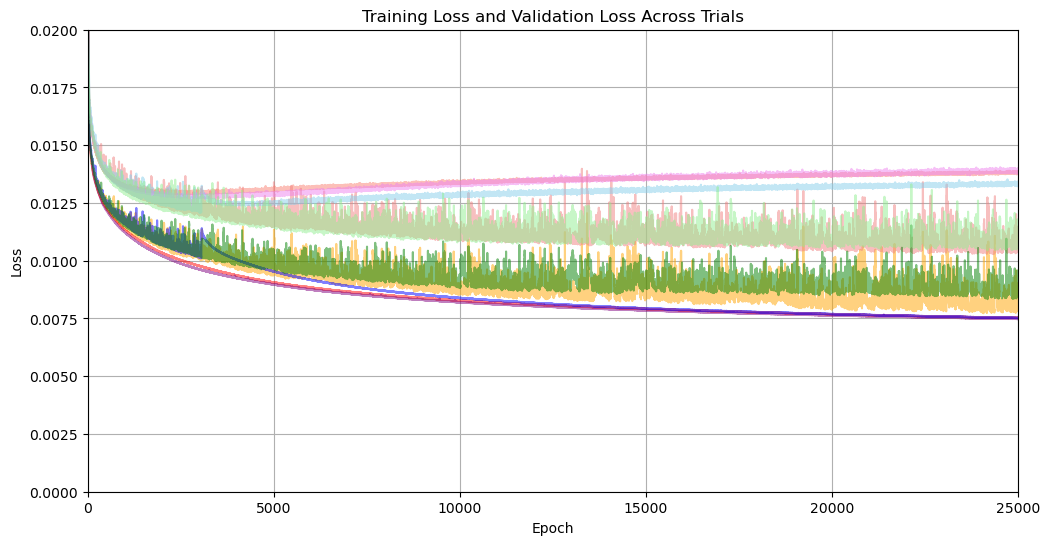

Trial 1:
  Minimum Loss: 0.007728 at Epoch 24072
  Minimum Validation Loss: 0.010288 at Epoch 24333
Trial 2:
  Minimum Loss: 0.007517 at Epoch 24928
  Minimum Validation Loss: 0.012845 at Epoch 2558
Trial 3:
  Minimum Loss: 0.007473 at Epoch 24977
  Minimum Validation Loss: 0.012718 at Epoch 3118
Trial 4:
  Minimum Loss: 0.007514 at Epoch 24980
  Minimum Validation Loss: 0.012078 at Epoch 3004
Trial 5:
  Minimum Loss: 0.008337 at Epoch 24179
  Minimum Validation Loss: 0.010445 at Epoch 24178
Average Difference Between Loss and Validation Loss (Epochs > 1000): -0.003793
Variability of Loss Across Trials (Epochs > 1000): 0.000461
Variability of Validation Loss Across Trials (Epochs > 1000): 0.001004


In [29]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the base folder where training loss data is stored
base_folder = 'AE_Grid_BS_256_LR_5/Half_Nodes_AE_Default_Data'
trial_colors = ['orange', 'red', 'purple', 'blue', 'green']
val_colors = ['lightcoral', 'salmon', 'violet', 'skyblue', 'lightgreen']

# Initialize lists to store global data for statistics
global_loss = []
global_val_loss = []

# Loop through each trial to collect and plot data
plt.figure(figsize=(12, 6))
for trial in range(1, 6):
    loss_data_folder = os.path.join(base_folder, f'AE_Training_{trial}/AE_Training_Loss_Data')
    all_loss = []
    all_val_loss = []
    
    # Load all training loss data for the current trial
    for counts in range(25):  # Adjust range if the number of files per trial differs
        history_file_path = os.path.join(loss_data_folder, f"{counts}_Autoencoder_Training_History.pkl")
        if os.path.exists(history_file_path):
            history = pd.read_pickle(history_file_path)
            all_loss.extend(history['loss'].tolist())
            all_val_loss.extend(history['val_loss'].tolist())
        else:
            print(f"Warning: Missing file for count {counts} in trial {trial}")
    
    # Ensure epoch indices are properly aligned with the number of epochs
    epochs = list(range(len(all_loss)))
    
    # Append to global lists for statistics
    global_loss.append(all_loss)
    global_val_loss.append(all_val_loss)
    
    # Plot loss and validation loss for the current trial
    plt.plot(epochs, all_loss, label=f'Trial {trial} Loss', color=trial_colors[trial - 1], alpha=0.5)
    plt.plot(epochs, all_val_loss, label=f'Trial {trial} Validation Loss', color=val_colors[trial - 1], alpha=0.5)

# Add plot details
plt.title('Training Loss and Validation Loss: 6 Layer, 0.5x Nodes AE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0, 25000)
plt.ylim(0, 0.02)
# plt.legend()
plt.grid()
plt.show()

# Calculate and print minimum loss and validation loss for each trial
for trial in range(5):
    trial_loss = np.array(global_loss[trial])
    trial_val_loss = np.array(global_val_loss[trial])
    
    # Find minimum loss and validation loss for the trial
    min_loss = np.min(trial_loss)
    min_loss_epoch = np.argmin(trial_loss)
    min_val_loss = np.min(trial_val_loss)
    min_val_loss_epoch = np.argmin(trial_val_loss)
    
    print(f"Trial {trial + 1}:")
    print(f"  Minimum Loss: {min_loss:.6f} at Epoch {min_loss_epoch}")
    print(f"  Minimum Validation Loss: {min_val_loss:.6f} at Epoch {min_val_loss_epoch}")

# Calculate average difference between loss and validation loss (ignoring first 1000 epochs)
avg_loss_val_loss_diff = np.mean([
    np.mean(np.array(global_loss[i][1000:]) - np.array(global_val_loss[i][1000:])) 
    for i in range(5)
])
print(f"Average Difference Between Loss and Validation Loss (Epochs > 1000): {avg_loss_val_loss_diff:.6f}")

# Calculate variability of loss and validation loss across trials (ignoring first 1000 epochs)
loss_variability = np.mean([
    np.std([global_loss[i][epoch] for i in range(5)]) 
    for epoch in range(1000, len(global_loss[0]))
])
val_loss_variability = np.mean([
    np.std([global_val_loss[i][epoch] for i in range(5)]) 
    for epoch in range(1000, len(global_val_loss[0]))
])

print(f"Variability of Loss Across Trials (Epochs > 1000): {loss_variability:.6f}")
print(f"Variability of Validation Loss Across Trials (Epochs > 1000): {val_loss_variability:.6f}")


# 0.25x Node Model

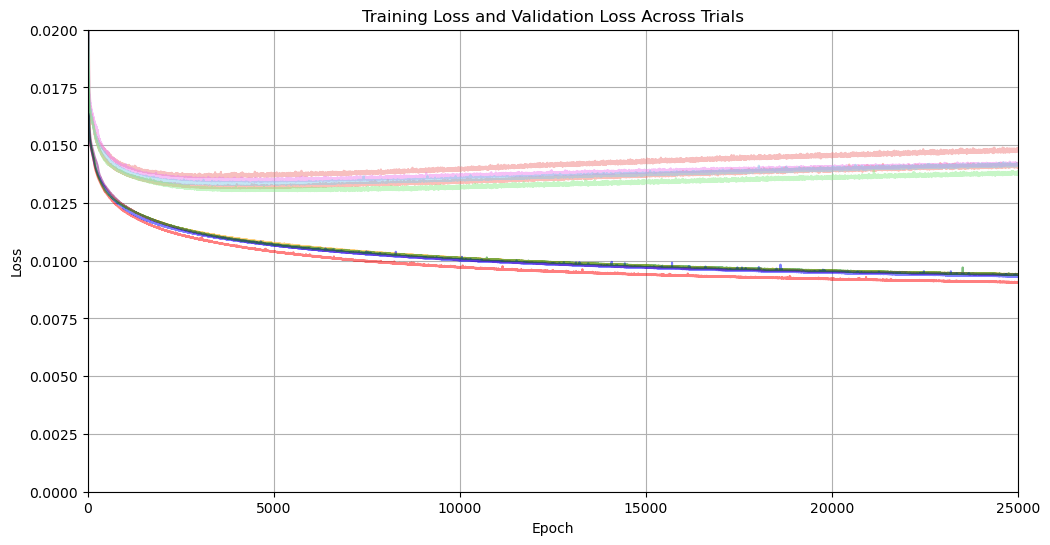

Trial 1:
  Minimum Loss: 0.009400 at Epoch 24934
  Minimum Validation Loss: 0.013614 at Epoch 3081
Trial 2:
  Minimum Loss: 0.009059 at Epoch 24962
  Minimum Validation Loss: 0.013131 at Epoch 4622
Trial 3:
  Minimum Loss: 0.009381 at Epoch 24963
  Minimum Validation Loss: 0.013410 at Epoch 5007
Trial 4:
  Minimum Loss: 0.009318 at Epoch 24990
  Minimum Validation Loss: 0.013269 at Epoch 3479
Trial 5:
  Minimum Loss: 0.009402 at Epoch 24972
  Minimum Validation Loss: 0.013006 at Epoch 6522
Average Difference Between Loss and Validation Loss (Epochs > 1000): -0.003722
Variability of Loss Across Trials (Epochs > 1000): 0.000136
Variability of Validation Loss Across Trials (Epochs > 1000): 0.000269


In [30]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the base folder where training loss data is stored
base_folder = 'AE_Grid_BS_256_LR_5/Fourth_Nodes_AE_Default_Data'
trial_colors = ['orange', 'red', 'purple', 'blue', 'green']
val_colors = ['lightcoral', 'salmon', 'violet', 'skyblue', 'lightgreen']

# Initialize lists to store global data for statistics
global_loss = []
global_val_loss = []

# Loop through each trial to collect and plot data
plt.figure(figsize=(12, 6))
for trial in range(1, 6):
    loss_data_folder = os.path.join(base_folder, f'AE_Training_{trial}/AE_Training_Loss_Data')
    all_loss = []
    all_val_loss = []
    
    # Load all training loss data for the current trial
    for counts in range(25):  # Adjust range if the number of files per trial differs
        history_file_path = os.path.join(loss_data_folder, f"{counts}_Autoencoder_Training_History.pkl")
        if os.path.exists(history_file_path):
            history = pd.read_pickle(history_file_path)
            all_loss.extend(history['loss'].tolist())
            all_val_loss.extend(history['val_loss'].tolist())
        else:
            print(f"Warning: Missing file for count {counts} in trial {trial}")
    
    # Ensure epoch indices are properly aligned with the number of epochs
    epochs = list(range(len(all_loss)))
    
    # Append to global lists for statistics
    global_loss.append(all_loss)
    global_val_loss.append(all_val_loss)
    
    # Plot loss and validation loss for the current trial
    plt.plot(epochs, all_loss, label=f'Trial {trial} Loss', color=trial_colors[trial - 1], alpha=0.5)
    plt.plot(epochs, all_val_loss, label=f'Trial {trial} Validation Loss', color=val_colors[trial - 1], alpha=0.5)

# Add plot details
plt.title('Training Loss and Validation Loss: 6 Layer, 0.25x Nodes AE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0, 25000)
plt.ylim(0, 0.02)
# plt.legend()
plt.grid()
plt.show()

# Calculate and print minimum loss and validation loss for each trial
for trial in range(5):
    trial_loss = np.array(global_loss[trial])
    trial_val_loss = np.array(global_val_loss[trial])
    
    # Find minimum loss and validation loss for the trial
    min_loss = np.min(trial_loss)
    min_loss_epoch = np.argmin(trial_loss)
    min_val_loss = np.min(trial_val_loss)
    min_val_loss_epoch = np.argmin(trial_val_loss)
    
    print(f"Trial {trial + 1}:")
    print(f"  Minimum Loss: {min_loss:.6f} at Epoch {min_loss_epoch}")
    print(f"  Minimum Validation Loss: {min_val_loss:.6f} at Epoch {min_val_loss_epoch}")

# Calculate average difference between loss and validation loss (ignoring first 1000 epochs)
avg_loss_val_loss_diff = np.mean([
    np.mean(np.array(global_loss[i][1000:]) - np.array(global_val_loss[i][1000:])) 
    for i in range(5)
])
print(f"Average Difference Between Loss and Validation Loss (Epochs > 1000): {avg_loss_val_loss_diff:.6f}")

# Calculate variability of loss and validation loss across trials (ignoring first 1000 epochs)
loss_variability = np.mean([
    np.std([global_loss[i][epoch] for i in range(5)]) 
    for epoch in range(1000, len(global_loss[0]))
])
val_loss_variability = np.mean([
    np.std([global_val_loss[i][epoch] for i in range(5)]) 
    for epoch in range(1000, len(global_val_loss[0]))
])

print(f"Variability of Loss Across Trials (Epochs > 1000): {loss_variability:.6f}")
print(f"Variability of Validation Loss Across Trials (Epochs > 1000): {val_loss_variability:.6f}")


### Batch Size: 256
### Learning Rate: 1x10^-5

# 8 Layer Model

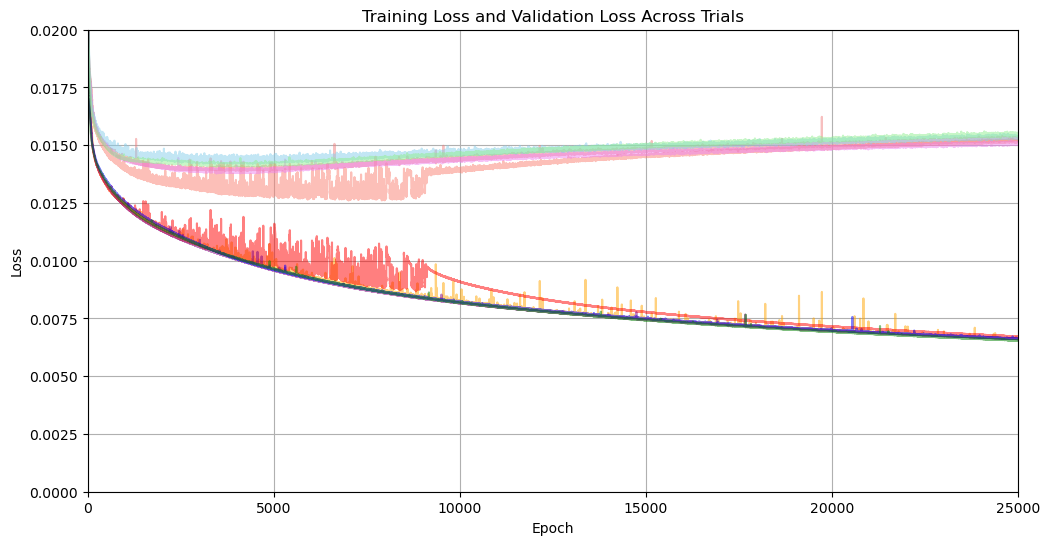

Trial 1:
  Minimum Loss: 0.006614 at Epoch 24959
  Minimum Validation Loss: 0.013873 at Epoch 4114
Trial 2:
  Minimum Loss: 0.006711 at Epoch 24994
  Minimum Validation Loss: 0.012606 at Epoch 7005
Trial 3:
  Minimum Loss: 0.006603 at Epoch 24996
  Minimum Validation Loss: 0.013774 at Epoch 3456
Trial 4:
  Minimum Loss: 0.006614 at Epoch 24856
  Minimum Validation Loss: 0.014190 at Epoch 4626
Trial 5:
  Minimum Loss: 0.006541 at Epoch 24982
  Minimum Validation Loss: 0.014077 at Epoch 3448
Average Difference Between Loss and Validation Loss (Epochs > 1000): -0.006336
Variability of Loss Across Trials (Epochs > 1000): 0.000147
Variability of Validation Loss Across Trials (Epochs > 1000): 0.000269


In [31]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the base folder where training loss data is stored
base_folder = 'AE_Grid_BS_128_LR_6/8_Layer_AE_Default_Data'
trial_colors = ['orange', 'red', 'purple', 'blue', 'green']
val_colors = ['lightcoral', 'salmon', 'violet', 'skyblue', 'lightgreen']

# Initialize lists to store global data for statistics
global_loss = []
global_val_loss = []

# Loop through each trial to collect and plot data
plt.figure(figsize=(12, 6))
for trial in range(1, 6):
    loss_data_folder = os.path.join(base_folder, f'AE_Training_{trial}/AE_Training_Loss_Data')
    all_loss = []
    all_val_loss = []
    
    # Load all training loss data for the current trial
    for counts in range(25):  # Adjust range if the number of files per trial differs
        history_file_path = os.path.join(loss_data_folder, f"{counts}_Autoencoder_Training_History.pkl")
        if os.path.exists(history_file_path):
            history = pd.read_pickle(history_file_path)
            all_loss.extend(history['loss'].tolist())
            all_val_loss.extend(history['val_loss'].tolist())
        else:
            print(f"Warning: Missing file for count {counts} in trial {trial}")
    
    # Ensure epoch indices are properly aligned with the number of epochs
    epochs = list(range(len(all_loss)))
    
    # Append to global lists for statistics
    global_loss.append(all_loss)
    global_val_loss.append(all_val_loss)
    
    # Plot loss and validation loss for the current trial
    plt.plot(epochs, all_loss, label=f'Trial {trial} Loss', color=trial_colors[trial - 1], alpha=0.5)
    plt.plot(epochs, all_val_loss, label=f'Trial {trial} Validation Loss', color=val_colors[trial - 1], alpha=0.5)

# Add plot details
plt.title('Training Loss and Validation Loss Across Trials')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0, 25000)
plt.ylim(0, 0.02)
# plt.legend()
plt.grid()
plt.show()

# Calculate and print minimum loss and validation loss for each trial
for trial in range(5):
    trial_loss = np.array(global_loss[trial])
    trial_val_loss = np.array(global_val_loss[trial])
    
    # Find minimum loss and validation loss for the trial
    min_loss = np.min(trial_loss)
    min_loss_epoch = np.argmin(trial_loss)
    min_val_loss = np.min(trial_val_loss)
    min_val_loss_epoch = np.argmin(trial_val_loss)
    
    print(f"Trial {trial + 1}:")
    print(f"  Minimum Loss: {min_loss:.6f} at Epoch {min_loss_epoch}")
    print(f"  Minimum Validation Loss: {min_val_loss:.6f} at Epoch {min_val_loss_epoch}")

# Calculate average difference between loss and validation loss (ignoring first 1000 epochs)
avg_loss_val_loss_diff = np.mean([
    np.mean(np.array(global_loss[i][1000:]) - np.array(global_val_loss[i][1000:])) 
    for i in range(5)
])
print(f"Average Difference Between Loss and Validation Loss (Epochs > 1000): {avg_loss_val_loss_diff:.6f}")

# Calculate variability of loss and validation loss across trials (ignoring first 1000 epochs)
loss_variability = np.mean([
    np.std([global_loss[i][epoch] for i in range(5)]) 
    for epoch in range(1000, len(global_loss[0]))
])
val_loss_variability = np.mean([
    np.std([global_val_loss[i][epoch] for i in range(5)]) 
    for epoch in range(1000, len(global_val_loss[0]))
])

print(f"Variability of Loss Across Trials (Epochs > 1000): {loss_variability:.6f}")
print(f"Variability of Validation Loss Across Trials (Epochs > 1000): {val_loss_variability:.6f}")

# 7 Layer Model

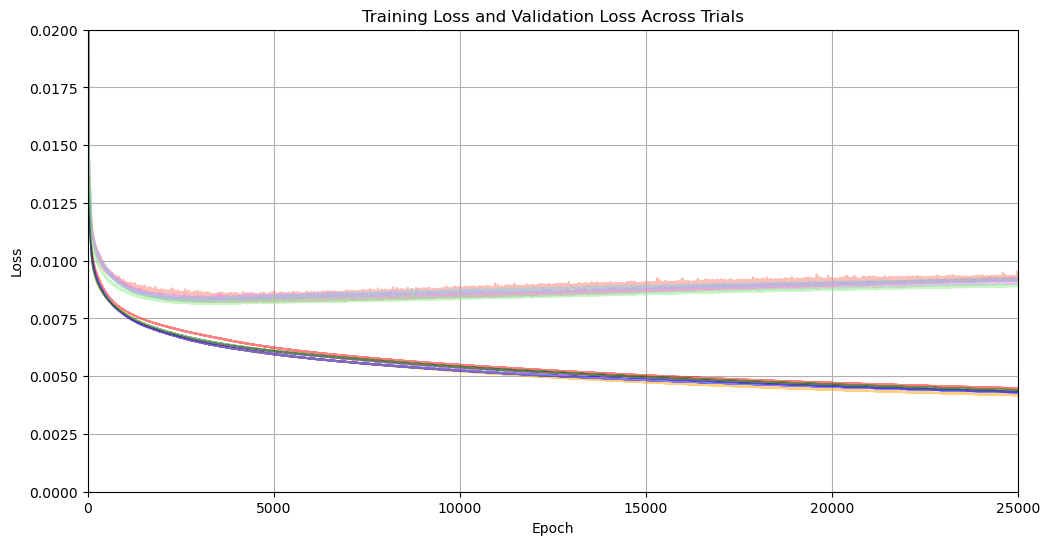

Trial 1:
  Minimum Loss: 0.004174 at Epoch 24935
  Minimum Validation Loss: 0.008205 at Epoch 3938
Trial 2:
  Minimum Loss: 0.004464 at Epoch 24946
  Minimum Validation Loss: 0.008308 at Epoch 4504
Trial 3:
  Minimum Loss: 0.004329 at Epoch 24987
  Minimum Validation Loss: 0.008210 at Epoch 3976
Trial 4:
  Minimum Loss: 0.004297 at Epoch 24999
  Minimum Validation Loss: 0.008257 at Epoch 3192
Trial 5:
  Minimum Loss: 0.004389 at Epoch 24983
  Minimum Validation Loss: 0.008127 at Epoch 3618
Average Difference Between Loss and Validation Loss (Epochs > 1000): -0.003432
Variability of Loss Across Trials (Epochs > 1000): 0.000103
Variability of Validation Loss Across Trials (Epochs > 1000): 0.000121


In [32]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the base folder where training loss data is stored
base_folder = 'AE_Grid_BS_128_LR_6/7_Layer_AE_Default_Data'
trial_colors = ['orange', 'red', 'purple', 'blue', 'green']
val_colors = ['lightcoral', 'salmon', 'violet', 'skyblue', 'lightgreen']

# Initialize lists to store global data for statistics
global_loss = []
global_val_loss = []

# Loop through each trial to collect and plot data
plt.figure(figsize=(12, 6))
for trial in range(1, 6):
    loss_data_folder = os.path.join(base_folder, f'AE_Training_{trial}/AE_Training_Loss_Data')
    all_loss = []
    all_val_loss = []
    
    # Load all training loss data for the current trial
    for counts in range(25):  # Adjust range if the number of files per trial differs
        history_file_path = os.path.join(loss_data_folder, f"{counts}_Autoencoder_Training_History.pkl")
        if os.path.exists(history_file_path):
            history = pd.read_pickle(history_file_path)
            all_loss.extend(history['loss'].tolist())
            all_val_loss.extend(history['val_loss'].tolist())
        else:
            print(f"Warning: Missing file for count {counts} in trial {trial}")
    
    # Ensure epoch indices are properly aligned with the number of epochs
    epochs = list(range(len(all_loss)))
    
    # Append to global lists for statistics
    global_loss.append(all_loss)
    global_val_loss.append(all_val_loss)
    
    # Plot loss and validation loss for the current trial
    plt.plot(epochs, all_loss, label=f'Trial {trial} Loss', color=trial_colors[trial - 1], alpha=0.5)
    plt.plot(epochs, all_val_loss, label=f'Trial {trial} Validation Loss', color=val_colors[trial - 1], alpha=0.5)

# Add plot details
plt.title('Training Loss and Validation Loss Across Trials')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0, 25000)
plt.ylim(0, 0.02)
# plt.legend()
plt.grid()
plt.show()

# Calculate and print minimum loss and validation loss for each trial
for trial in range(5):
    trial_loss = np.array(global_loss[trial])
    trial_val_loss = np.array(global_val_loss[trial])
    
    # Find minimum loss and validation loss for the trial
    min_loss = np.min(trial_loss)
    min_loss_epoch = np.argmin(trial_loss)
    min_val_loss = np.min(trial_val_loss)
    min_val_loss_epoch = np.argmin(trial_val_loss)
    
    print(f"Trial {trial + 1}:")
    print(f"  Minimum Loss: {min_loss:.6f} at Epoch {min_loss_epoch}")
    print(f"  Minimum Validation Loss: {min_val_loss:.6f} at Epoch {min_val_loss_epoch}")

# Calculate average difference between loss and validation loss (ignoring first 1000 epochs)
avg_loss_val_loss_diff = np.mean([
    np.mean(np.array(global_loss[i][1000:]) - np.array(global_val_loss[i][1000:])) 
    for i in range(5)
])
print(f"Average Difference Between Loss and Validation Loss (Epochs > 1000): {avg_loss_val_loss_diff:.6f}")

# Calculate variability of loss and validation loss across trials (ignoring first 1000 epochs)
loss_variability = np.mean([
    np.std([global_loss[i][epoch] for i in range(5)]) 
    for epoch in range(1000, len(global_loss[0]))
])
val_loss_variability = np.mean([
    np.std([global_val_loss[i][epoch] for i in range(5)]) 
    for epoch in range(1000, len(global_val_loss[0]))
])

print(f"Variability of Loss Across Trials (Epochs > 1000): {loss_variability:.6f}")
print(f"Variability of Validation Loss Across Trials (Epochs > 1000): {val_loss_variability:.6f}")

# 6 Layer Model

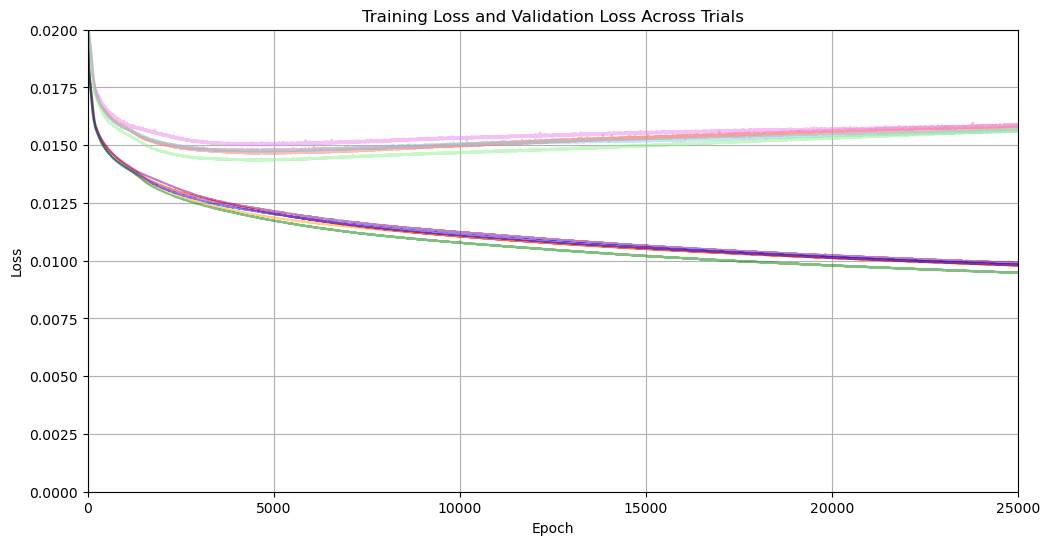

Trial 1:
  Minimum Loss: 0.009790 at Epoch 24952
  Minimum Validation Loss: 0.014723 at Epoch 4339
Trial 2:
  Minimum Loss: 0.009796 at Epoch 24982
  Minimum Validation Loss: 0.014624 at Epoch 4604
Trial 3:
  Minimum Loss: 0.009894 at Epoch 24872
  Minimum Validation Loss: 0.015022 at Epoch 4460
Trial 4:
  Minimum Loss: 0.009812 at Epoch 24981
  Minimum Validation Loss: 0.014720 at Epoch 4232
Trial 5:
  Minimum Loss: 0.009474 at Epoch 24953
  Minimum Validation Loss: 0.014337 at Epoch 4617
Average Difference Between Loss and Validation Loss (Epochs > 1000): -0.004247
Variability of Loss Across Trials (Epochs > 1000): 0.000145
Variability of Validation Loss Across Trials (Epochs > 1000): 0.000176


In [33]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the base folder where training loss data is stored
base_folder = 'AE_Grid_BS_128_LR_6/Default_AE_Default_Data'
trial_colors = ['orange', 'red', 'purple', 'blue', 'green']
val_colors = ['lightcoral', 'salmon', 'violet', 'skyblue', 'lightgreen']

# Initialize lists to store global data for statistics
global_loss = []
global_val_loss = []

# Loop through each trial to collect and plot data
plt.figure(figsize=(12, 6))
for trial in range(1, 6):
    loss_data_folder = os.path.join(base_folder, f'AE_Training_{trial}/AE_Training_Loss_Data')
    all_loss = []
    all_val_loss = []
    
    # Load all training loss data for the current trial
    for counts in range(25):  # Adjust range if the number of files per trial differs
        history_file_path = os.path.join(loss_data_folder, f"{counts}_Autoencoder_Training_History.pkl")
        if os.path.exists(history_file_path):
            history = pd.read_pickle(history_file_path)
            all_loss.extend(history['loss'].tolist())
            all_val_loss.extend(history['val_loss'].tolist())
        else:
            print(f"Warning: Missing file for count {counts} in trial {trial}")
    
    # Ensure epoch indices are properly aligned with the number of epochs
    epochs = list(range(len(all_loss)))
    
    # Append to global lists for statistics
    global_loss.append(all_loss)
    global_val_loss.append(all_val_loss)
    
    # Plot loss and validation loss for the current trial
    plt.plot(epochs, all_loss, label=f'Trial {trial} Loss', color=trial_colors[trial - 1], alpha=0.5)
    plt.plot(epochs, all_val_loss, label=f'Trial {trial} Validation Loss', color=val_colors[trial - 1], alpha=0.5)

# Add plot details
plt.title('Training Loss and Validation Loss Across Trials')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0, 25000)
plt.ylim(0, 0.02)
# plt.legend()
plt.grid()
plt.show()

# Calculate and print minimum loss and validation loss for each trial
for trial in range(5):
    trial_loss = np.array(global_loss[trial])
    trial_val_loss = np.array(global_val_loss[trial])
    
    # Find minimum loss and validation loss for the trial
    min_loss = np.min(trial_loss)
    min_loss_epoch = np.argmin(trial_loss)
    min_val_loss = np.min(trial_val_loss)
    min_val_loss_epoch = np.argmin(trial_val_loss)
    
    print(f"Trial {trial + 1}:")
    print(f"  Minimum Loss: {min_loss:.6f} at Epoch {min_loss_epoch}")
    print(f"  Minimum Validation Loss: {min_val_loss:.6f} at Epoch {min_val_loss_epoch}")

# Calculate average difference between loss and validation loss (ignoring first 1000 epochs)
avg_loss_val_loss_diff = np.mean([
    np.mean(np.array(global_loss[i][1000:]) - np.array(global_val_loss[i][1000:])) 
    for i in range(5)
])
print(f"Average Difference Between Loss and Validation Loss (Epochs > 1000): {avg_loss_val_loss_diff:.6f}")

# Calculate variability of loss and validation loss across trials (ignoring first 1000 epochs)
loss_variability = np.mean([
    np.std([global_loss[i][epoch] for i in range(5)]) 
    for epoch in range(1000, len(global_loss[0]))
])
val_loss_variability = np.mean([
    np.std([global_val_loss[i][epoch] for i in range(5)]) 
    for epoch in range(1000, len(global_val_loss[0]))
])

print(f"Variability of Loss Across Trials (Epochs > 1000): {loss_variability:.6f}")
print(f"Variability of Validation Loss Across Trials (Epochs > 1000): {val_loss_variability:.6f}")

# 5 Layer Model

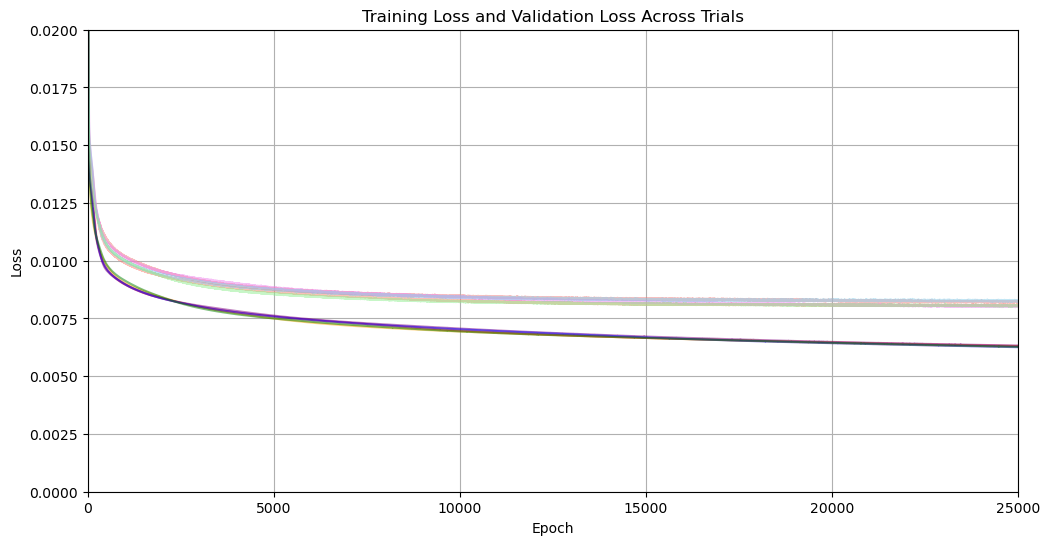

Trial 1:
  Minimum Loss: 0.006269 at Epoch 24962
  Minimum Validation Loss: 0.008181 at Epoch 24853
Trial 2:
  Minimum Loss: 0.006308 at Epoch 24997
  Minimum Validation Loss: 0.008029 at Epoch 24908
Trial 3:
  Minimum Loss: 0.006326 at Epoch 24992
  Minimum Validation Loss: 0.007986 at Epoch 24931
Trial 4:
  Minimum Loss: 0.006256 at Epoch 24979
  Minimum Validation Loss: 0.008229 at Epoch 22155
Trial 5:
  Minimum Loss: 0.006275 at Epoch 24997
  Minimum Validation Loss: 0.008016 at Epoch 24508
Average Difference Between Loss and Validation Loss (Epochs > 1000): -0.001459
Variability of Loss Across Trials (Epochs > 1000): 0.000035
Variability of Validation Loss Across Trials (Epochs > 1000): 0.000093


In [34]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the base folder where training loss data is stored
base_folder = 'AE_Grid_BS_128_LR_6/5_Layer_AE_Default_Data'
trial_colors = ['orange', 'red', 'purple', 'blue', 'green']
val_colors = ['lightcoral', 'salmon', 'violet', 'skyblue', 'lightgreen']

# Initialize lists to store global data for statistics
global_loss = []
global_val_loss = []

# Loop through each trial to collect and plot data
plt.figure(figsize=(12, 6))
for trial in range(1, 6):
    loss_data_folder = os.path.join(base_folder, f'AE_Training_{trial}/AE_Training_Loss_Data')
    all_loss = []
    all_val_loss = []
    
    # Load all training loss data for the current trial
    for counts in range(25):  # Adjust range if the number of files per trial differs
        history_file_path = os.path.join(loss_data_folder, f"{counts}_Autoencoder_Training_History.pkl")
        if os.path.exists(history_file_path):
            history = pd.read_pickle(history_file_path)
            all_loss.extend(history['loss'].tolist())
            all_val_loss.extend(history['val_loss'].tolist())
        else:
            print(f"Warning: Missing file for count {counts} in trial {trial}")
    
    # Ensure epoch indices are properly aligned with the number of epochs
    epochs = list(range(len(all_loss)))
    
    # Append to global lists for statistics
    global_loss.append(all_loss)
    global_val_loss.append(all_val_loss)
    
    # Plot loss and validation loss for the current trial
    plt.plot(epochs, all_loss, label=f'Trial {trial} Loss', color=trial_colors[trial - 1], alpha=0.5)
    plt.plot(epochs, all_val_loss, label=f'Trial {trial} Validation Loss', color=val_colors[trial - 1], alpha=0.5)

# Add plot details
plt.title('Training Loss and Validation Loss Across Trials')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0, 25000)
plt.ylim(0, 0.02)
# plt.legend()
plt.grid()
plt.show()

# Calculate and print minimum loss and validation loss for each trial
for trial in range(5):
    trial_loss = np.array(global_loss[trial])
    trial_val_loss = np.array(global_val_loss[trial])
    
    # Find minimum loss and validation loss for the trial
    min_loss = np.min(trial_loss)
    min_loss_epoch = np.argmin(trial_loss)
    min_val_loss = np.min(trial_val_loss)
    min_val_loss_epoch = np.argmin(trial_val_loss)
    
    print(f"Trial {trial + 1}:")
    print(f"  Minimum Loss: {min_loss:.6f} at Epoch {min_loss_epoch}")
    print(f"  Minimum Validation Loss: {min_val_loss:.6f} at Epoch {min_val_loss_epoch}")

# Calculate average difference between loss and validation loss (ignoring first 1000 epochs)
avg_loss_val_loss_diff = np.mean([
    np.mean(np.array(global_loss[i][1000:]) - np.array(global_val_loss[i][1000:])) 
    for i in range(5)
])
print(f"Average Difference Between Loss and Validation Loss (Epochs > 1000): {avg_loss_val_loss_diff:.6f}")

# Calculate variability of loss and validation loss across trials (ignoring first 1000 epochs)
loss_variability = np.mean([
    np.std([global_loss[i][epoch] for i in range(5)]) 
    for epoch in range(1000, len(global_loss[0]))
])
val_loss_variability = np.mean([
    np.std([global_val_loss[i][epoch] for i in range(5)]) 
    for epoch in range(1000, len(global_val_loss[0]))
])

print(f"Variability of Loss Across Trials (Epochs > 1000): {loss_variability:.6f}")
print(f"Variability of Validation Loss Across Trials (Epochs > 1000): {val_loss_variability:.6f}")

# 4 Layer Model

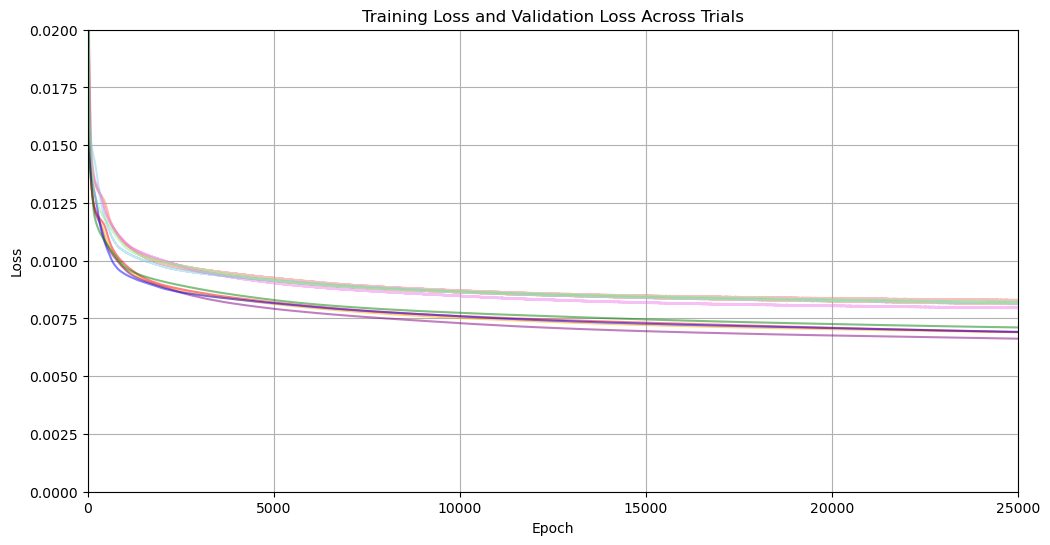

Trial 1:
  Minimum Loss: 0.006908 at Epoch 24998
  Minimum Validation Loss: 0.008270 at Epoch 24900
Trial 2:
  Minimum Loss: 0.006907 at Epoch 24993
  Minimum Validation Loss: 0.008116 at Epoch 24766
Trial 3:
  Minimum Loss: 0.006625 at Epoch 24976
  Minimum Validation Loss: 0.007941 at Epoch 24998
Trial 4:
  Minimum Loss: 0.006920 at Epoch 24997
  Minimum Validation Loss: 0.008146 at Epoch 24999
Trial 5:
  Minimum Loss: 0.007110 at Epoch 24990
  Minimum Validation Loss: 0.008184 at Epoch 24951
Average Difference Between Loss and Validation Loss (Epochs > 1000): -0.001113
Variability of Loss Across Trials (Epochs > 1000): 0.000147
Variability of Validation Loss Across Trials (Epochs > 1000): 0.000092


In [35]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the base folder where training loss data is stored
base_folder = 'AE_Grid_BS_128_LR_6/4_Layer_AE_Default_Data'
trial_colors = ['orange', 'red', 'purple', 'blue', 'green']
val_colors = ['lightcoral', 'salmon', 'violet', 'skyblue', 'lightgreen']

# Initialize lists to store global data for statistics
global_loss = []
global_val_loss = []

# Loop through each trial to collect and plot data
plt.figure(figsize=(12, 6))
for trial in range(1, 6):
    loss_data_folder = os.path.join(base_folder, f'AE_Training_{trial}/AE_Training_Loss_Data')
    all_loss = []
    all_val_loss = []
    
    # Load all training loss data for the current trial
    for counts in range(25):  # Adjust range if the number of files per trial differs
        history_file_path = os.path.join(loss_data_folder, f"{counts}_Autoencoder_Training_History.pkl")
        if os.path.exists(history_file_path):
            history = pd.read_pickle(history_file_path)
            all_loss.extend(history['loss'].tolist())
            all_val_loss.extend(history['val_loss'].tolist())
        else:
            print(f"Warning: Missing file for count {counts} in trial {trial}")
    
    # Ensure epoch indices are properly aligned with the number of epochs
    epochs = list(range(len(all_loss)))
    
    # Append to global lists for statistics
    global_loss.append(all_loss)
    global_val_loss.append(all_val_loss)
    
    # Plot loss and validation loss for the current trial
    plt.plot(epochs, all_loss, label=f'Trial {trial} Loss', color=trial_colors[trial - 1], alpha=0.5)
    plt.plot(epochs, all_val_loss, label=f'Trial {trial} Validation Loss', color=val_colors[trial - 1], alpha=0.5)

# Add plot details
plt.title('Training Loss and Validation Loss Across Trials')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0, 25000)
plt.ylim(0, 0.02)
# plt.legend()
plt.grid()
plt.show()

# Calculate and print minimum loss and validation loss for each trial
for trial in range(5):
    trial_loss = np.array(global_loss[trial])
    trial_val_loss = np.array(global_val_loss[trial])
    
    # Find minimum loss and validation loss for the trial
    min_loss = np.min(trial_loss)
    min_loss_epoch = np.argmin(trial_loss)
    min_val_loss = np.min(trial_val_loss)
    min_val_loss_epoch = np.argmin(trial_val_loss)
    
    print(f"Trial {trial + 1}:")
    print(f"  Minimum Loss: {min_loss:.6f} at Epoch {min_loss_epoch}")
    print(f"  Minimum Validation Loss: {min_val_loss:.6f} at Epoch {min_val_loss_epoch}")

# Calculate average difference between loss and validation loss (ignoring first 1000 epochs)
avg_loss_val_loss_diff = np.mean([
    np.mean(np.array(global_loss[i][1000:]) - np.array(global_val_loss[i][1000:])) 
    for i in range(5)
])
print(f"Average Difference Between Loss and Validation Loss (Epochs > 1000): {avg_loss_val_loss_diff:.6f}")

# Calculate variability of loss and validation loss across trials (ignoring first 1000 epochs)
loss_variability = np.mean([
    np.std([global_loss[i][epoch] for i in range(5)]) 
    for epoch in range(1000, len(global_loss[0]))
])
val_loss_variability = np.mean([
    np.std([global_val_loss[i][epoch] for i in range(5)]) 
    for epoch in range(1000, len(global_val_loss[0]))
])

print(f"Variability of Loss Across Trials (Epochs > 1000): {loss_variability:.6f}")
print(f"Variability of Validation Loss Across Trials (Epochs > 1000): {val_loss_variability:.6f}")

# 4x Node Model

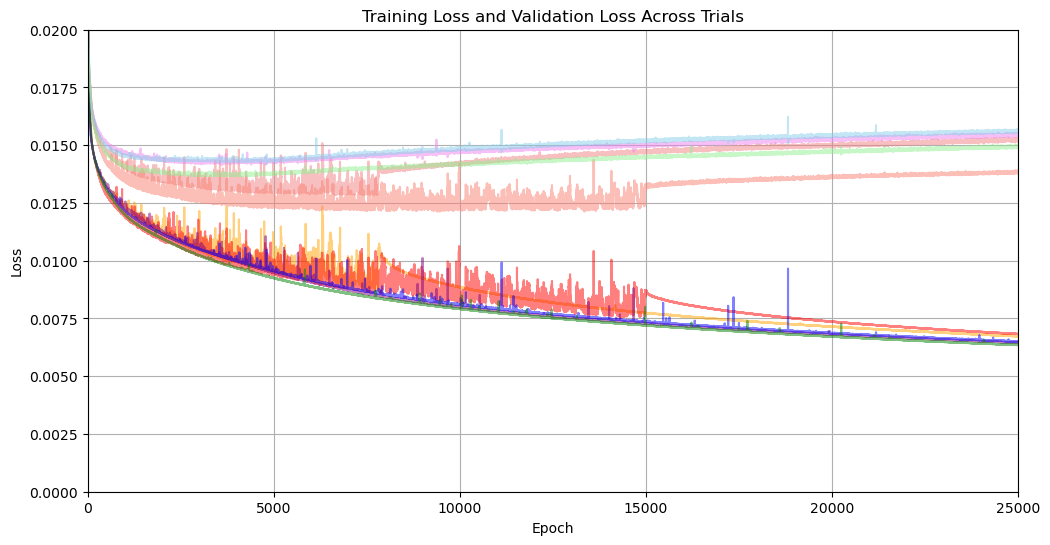

Trial 1:
  Minimum Loss: 0.006723 at Epoch 24939
  Minimum Validation Loss: 0.012825 at Epoch 7686
Trial 2:
  Minimum Loss: 0.006825 at Epoch 24987
  Minimum Validation Loss: 0.012125 at Epoch 13343
Trial 3:
  Minimum Loss: 0.006443 at Epoch 24965
  Minimum Validation Loss: 0.014135 at Epoch 3596
Trial 4:
  Minimum Loss: 0.006494 at Epoch 24946
  Minimum Validation Loss: 0.014193 at Epoch 4804
Trial 5:
  Minimum Loss: 0.006345 at Epoch 24930
  Minimum Validation Loss: 0.013663 at Epoch 4094
Average Difference Between Loss and Validation Loss (Epochs > 1000): -0.006131
Variability of Loss Across Trials (Epochs > 1000): 0.000283
Variability of Validation Loss Across Trials (Epochs > 1000): 0.000722


In [36]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the base folder where training loss data is stored
base_folder = 'AE_Grid_BS_128_LR_6/4x_Nodes_AE_Default_Data'
trial_colors = ['orange', 'red', 'purple', 'blue', 'green']
val_colors = ['lightcoral', 'salmon', 'violet', 'skyblue', 'lightgreen']

# Initialize lists to store global data for statistics
global_loss = []
global_val_loss = []

# Loop through each trial to collect and plot data
plt.figure(figsize=(12, 6))
for trial in range(1, 6):
    loss_data_folder = os.path.join(base_folder, f'AE_Training_{trial}/AE_Training_Loss_Data')
    all_loss = []
    all_val_loss = []
    
    # Load all training loss data for the current trial
    for counts in range(25):  # Adjust range if the number of files per trial differs
        history_file_path = os.path.join(loss_data_folder, f"{counts}_Autoencoder_Training_History.pkl")
        if os.path.exists(history_file_path):
            history = pd.read_pickle(history_file_path)
            all_loss.extend(history['loss'].tolist())
            all_val_loss.extend(history['val_loss'].tolist())
        else:
            print(f"Warning: Missing file for count {counts} in trial {trial}")
    
    # Ensure epoch indices are properly aligned with the number of epochs
    epochs = list(range(len(all_loss)))
    
    # Append to global lists for statistics
    global_loss.append(all_loss)
    global_val_loss.append(all_val_loss)
    
    # Plot loss and validation loss for the current trial
    plt.plot(epochs, all_loss, label=f'Trial {trial} Loss', color=trial_colors[trial - 1], alpha=0.5)
    plt.plot(epochs, all_val_loss, label=f'Trial {trial} Validation Loss', color=val_colors[trial - 1], alpha=0.5)

# Add plot details
plt.title('Training Loss and Validation Loss Across Trials')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0, 25000)
plt.ylim(0, 0.02)
# plt.legend()
plt.grid()
plt.show()

# Calculate and print minimum loss and validation loss for each trial
for trial in range(5):
    trial_loss = np.array(global_loss[trial])
    trial_val_loss = np.array(global_val_loss[trial])
    
    # Find minimum loss and validation loss for the trial
    min_loss = np.min(trial_loss)
    min_loss_epoch = np.argmin(trial_loss)
    min_val_loss = np.min(trial_val_loss)
    min_val_loss_epoch = np.argmin(trial_val_loss)
    
    print(f"Trial {trial + 1}:")
    print(f"  Minimum Loss: {min_loss:.6f} at Epoch {min_loss_epoch}")
    print(f"  Minimum Validation Loss: {min_val_loss:.6f} at Epoch {min_val_loss_epoch}")

# Calculate average difference between loss and validation loss (ignoring first 1000 epochs)
avg_loss_val_loss_diff = np.mean([
    np.mean(np.array(global_loss[i][1000:]) - np.array(global_val_loss[i][1000:])) 
    for i in range(5)
])
print(f"Average Difference Between Loss and Validation Loss (Epochs > 1000): {avg_loss_val_loss_diff:.6f}")

# Calculate variability of loss and validation loss across trials (ignoring first 1000 epochs)
loss_variability = np.mean([
    np.std([global_loss[i][epoch] for i in range(5)]) 
    for epoch in range(1000, len(global_loss[0]))
])
val_loss_variability = np.mean([
    np.std([global_val_loss[i][epoch] for i in range(5)]) 
    for epoch in range(1000, len(global_val_loss[0]))
])

print(f"Variability of Loss Across Trials (Epochs > 1000): {loss_variability:.6f}")
print(f"Variability of Validation Loss Across Trials (Epochs > 1000): {val_loss_variability:.6f}")

# 2x Node Model

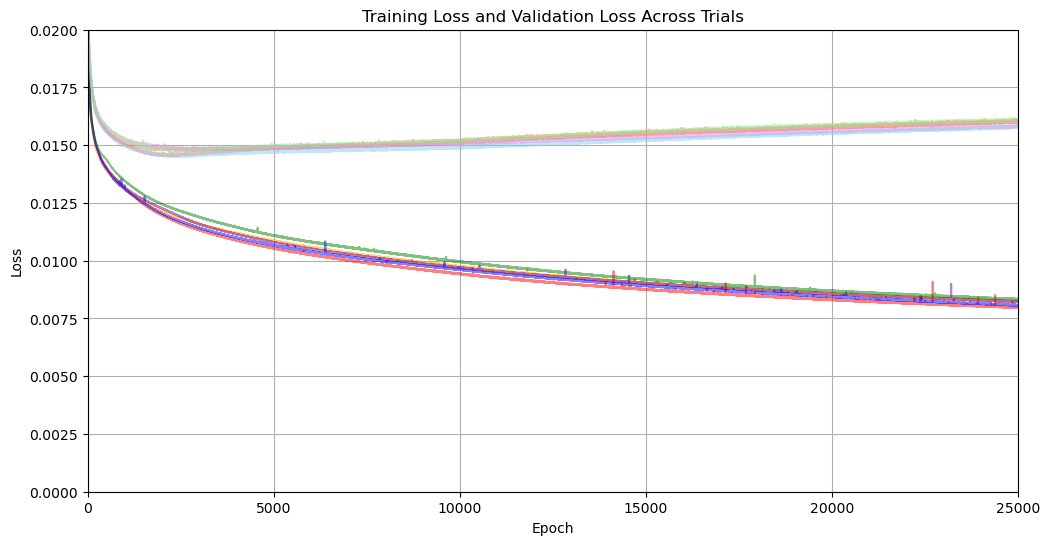

Trial 1:
  Minimum Loss: 0.008238 at Epoch 24959
  Minimum Validation Loss: 0.014758 at Epoch 2359
Trial 2:
  Minimum Loss: 0.007962 at Epoch 24971
  Minimum Validation Loss: 0.014539 at Epoch 2329
Trial 3:
  Minimum Loss: 0.008211 at Epoch 24989
  Minimum Validation Loss: 0.014773 at Epoch 3085
Trial 4:
  Minimum Loss: 0.008058 at Epoch 24988
  Minimum Validation Loss: 0.014490 at Epoch 2271
Trial 5:
  Minimum Loss: 0.008324 at Epoch 24911
  Minimum Validation Loss: 0.014786 at Epoch 2567
Average Difference Between Loss and Validation Loss (Epochs > 1000): -0.005747
Variability of Loss Across Trials (Epochs > 1000): 0.000157
Variability of Validation Loss Across Trials (Epochs > 1000): 0.000116


In [37]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the base folder where training loss data is stored
base_folder = 'AE_Grid_BS_128_LR_6/2x_Nodes_AE_Default_Data'
trial_colors = ['orange', 'red', 'purple', 'blue', 'green']
val_colors = ['lightcoral', 'salmon', 'violet', 'skyblue', 'lightgreen']

# Initialize lists to store global data for statistics
global_loss = []
global_val_loss = []

# Loop through each trial to collect and plot data
plt.figure(figsize=(12, 6))
for trial in range(1, 6):
    loss_data_folder = os.path.join(base_folder, f'AE_Training_{trial}/AE_Training_Loss_Data')
    all_loss = []
    all_val_loss = []
    
    # Load all training loss data for the current trial
    for counts in range(25):  # Adjust range if the number of files per trial differs
        history_file_path = os.path.join(loss_data_folder, f"{counts}_Autoencoder_Training_History.pkl")
        if os.path.exists(history_file_path):
            history = pd.read_pickle(history_file_path)
            all_loss.extend(history['loss'].tolist())
            all_val_loss.extend(history['val_loss'].tolist())
        else:
            print(f"Warning: Missing file for count {counts} in trial {trial}")
    
    # Ensure epoch indices are properly aligned with the number of epochs
    epochs = list(range(len(all_loss)))
    
    # Append to global lists for statistics
    global_loss.append(all_loss)
    global_val_loss.append(all_val_loss)
    
    # Plot loss and validation loss for the current trial
    plt.plot(epochs, all_loss, label=f'Trial {trial} Loss', color=trial_colors[trial - 1], alpha=0.5)
    plt.plot(epochs, all_val_loss, label=f'Trial {trial} Validation Loss', color=val_colors[trial - 1], alpha=0.5)

# Add plot details
plt.title('Training Loss and Validation Loss Across Trials')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0, 25000)
plt.ylim(0, 0.02)
# plt.legend()
plt.grid()
plt.show()

# Calculate and print minimum loss and validation loss for each trial
for trial in range(5):
    trial_loss = np.array(global_loss[trial])
    trial_val_loss = np.array(global_val_loss[trial])
    
    # Find minimum loss and validation loss for the trial
    min_loss = np.min(trial_loss)
    min_loss_epoch = np.argmin(trial_loss)
    min_val_loss = np.min(trial_val_loss)
    min_val_loss_epoch = np.argmin(trial_val_loss)
    
    print(f"Trial {trial + 1}:")
    print(f"  Minimum Loss: {min_loss:.6f} at Epoch {min_loss_epoch}")
    print(f"  Minimum Validation Loss: {min_val_loss:.6f} at Epoch {min_val_loss_epoch}")

# Calculate average difference between loss and validation loss (ignoring first 1000 epochs)
avg_loss_val_loss_diff = np.mean([
    np.mean(np.array(global_loss[i][1000:]) - np.array(global_val_loss[i][1000:])) 
    for i in range(5)
])
print(f"Average Difference Between Loss and Validation Loss (Epochs > 1000): {avg_loss_val_loss_diff:.6f}")

# Calculate variability of loss and validation loss across trials (ignoring first 1000 epochs)
loss_variability = np.mean([
    np.std([global_loss[i][epoch] for i in range(5)]) 
    for epoch in range(1000, len(global_loss[0]))
])
val_loss_variability = np.mean([
    np.std([global_val_loss[i][epoch] for i in range(5)]) 
    for epoch in range(1000, len(global_val_loss[0]))
])

print(f"Variability of Loss Across Trials (Epochs > 1000): {loss_variability:.6f}")
print(f"Variability of Validation Loss Across Trials (Epochs > 1000): {val_loss_variability:.6f}")

# 0.5x Node Model

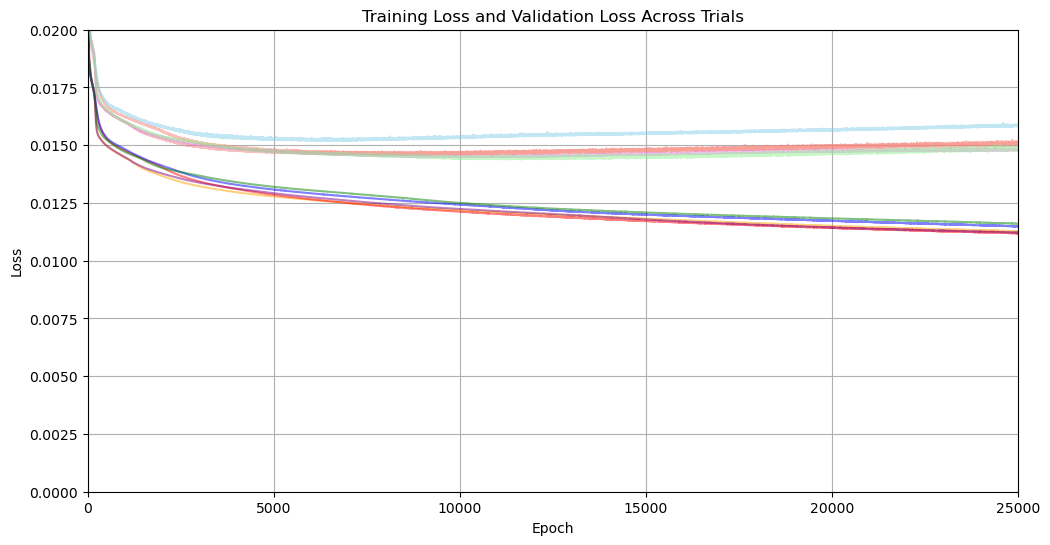

Trial 1:
  Minimum Loss: 0.011273 at Epoch 24994
  Minimum Validation Loss: 0.014578 at Epoch 7713
Trial 2:
  Minimum Loss: 0.011185 at Epoch 24975
  Minimum Validation Loss: 0.014546 at Epoch 10851
Trial 3:
  Minimum Loss: 0.011219 at Epoch 24978
  Minimum Validation Loss: 0.014482 at Epoch 10694
Trial 4:
  Minimum Loss: 0.011483 at Epoch 24992
  Minimum Validation Loss: 0.015185 at Epoch 6291
Trial 5:
  Minimum Loss: 0.011602 at Epoch 24999
  Minimum Validation Loss: 0.014382 at Epoch 11659
Average Difference Between Loss and Validation Loss (Epochs > 1000): -0.002703
Variability of Loss Across Trials (Epochs > 1000): 0.000155
Variability of Validation Loss Across Trials (Epochs > 1000): 0.000308


In [38]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the base folder where training loss data is stored
base_folder = 'AE_Grid_BS_128_LR_6/Half_Nodes_AE_Default_Data'
trial_colors = ['orange', 'red', 'purple', 'blue', 'green']
val_colors = ['lightcoral', 'salmon', 'violet', 'skyblue', 'lightgreen']

# Initialize lists to store global data for statistics
global_loss = []
global_val_loss = []

# Loop through each trial to collect and plot data
plt.figure(figsize=(12, 6))
for trial in range(1, 6):
    loss_data_folder = os.path.join(base_folder, f'AE_Training_{trial}/AE_Training_Loss_Data')
    all_loss = []
    all_val_loss = []
    
    # Load all training loss data for the current trial
    for counts in range(25):  # Adjust range if the number of files per trial differs
        history_file_path = os.path.join(loss_data_folder, f"{counts}_Autoencoder_Training_History.pkl")
        if os.path.exists(history_file_path):
            history = pd.read_pickle(history_file_path)
            all_loss.extend(history['loss'].tolist())
            all_val_loss.extend(history['val_loss'].tolist())
        else:
            print(f"Warning: Missing file for count {counts} in trial {trial}")
    
    # Ensure epoch indices are properly aligned with the number of epochs
    epochs = list(range(len(all_loss)))
    
    # Append to global lists for statistics
    global_loss.append(all_loss)
    global_val_loss.append(all_val_loss)
    
    # Plot loss and validation loss for the current trial
    plt.plot(epochs, all_loss, label=f'Trial {trial} Loss', color=trial_colors[trial - 1], alpha=0.5)
    plt.plot(epochs, all_val_loss, label=f'Trial {trial} Validation Loss', color=val_colors[trial - 1], alpha=0.5)

# Add plot details
plt.title('Training Loss and Validation Loss Across Trials')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0, 25000)
plt.ylim(0, 0.02)
# plt.legend()
plt.grid()
plt.show()

# Calculate and print minimum loss and validation loss for each trial
for trial in range(5):
    trial_loss = np.array(global_loss[trial])
    trial_val_loss = np.array(global_val_loss[trial])
    
    # Find minimum loss and validation loss for the trial
    min_loss = np.min(trial_loss)
    min_loss_epoch = np.argmin(trial_loss)
    min_val_loss = np.min(trial_val_loss)
    min_val_loss_epoch = np.argmin(trial_val_loss)
    
    print(f"Trial {trial + 1}:")
    print(f"  Minimum Loss: {min_loss:.6f} at Epoch {min_loss_epoch}")
    print(f"  Minimum Validation Loss: {min_val_loss:.6f} at Epoch {min_val_loss_epoch}")

# Calculate average difference between loss and validation loss (ignoring first 1000 epochs)
avg_loss_val_loss_diff = np.mean([
    np.mean(np.array(global_loss[i][1000:]) - np.array(global_val_loss[i][1000:])) 
    for i in range(5)
])
print(f"Average Difference Between Loss and Validation Loss (Epochs > 1000): {avg_loss_val_loss_diff:.6f}")

# Calculate variability of loss and validation loss across trials (ignoring first 1000 epochs)
loss_variability = np.mean([
    np.std([global_loss[i][epoch] for i in range(5)]) 
    for epoch in range(1000, len(global_loss[0]))
])
val_loss_variability = np.mean([
    np.std([global_val_loss[i][epoch] for i in range(5)]) 
    for epoch in range(1000, len(global_val_loss[0]))
])

print(f"Variability of Loss Across Trials (Epochs > 1000): {loss_variability:.6f}")
print(f"Variability of Validation Loss Across Trials (Epochs > 1000): {val_loss_variability:.6f}")

# 0.25x Node Model

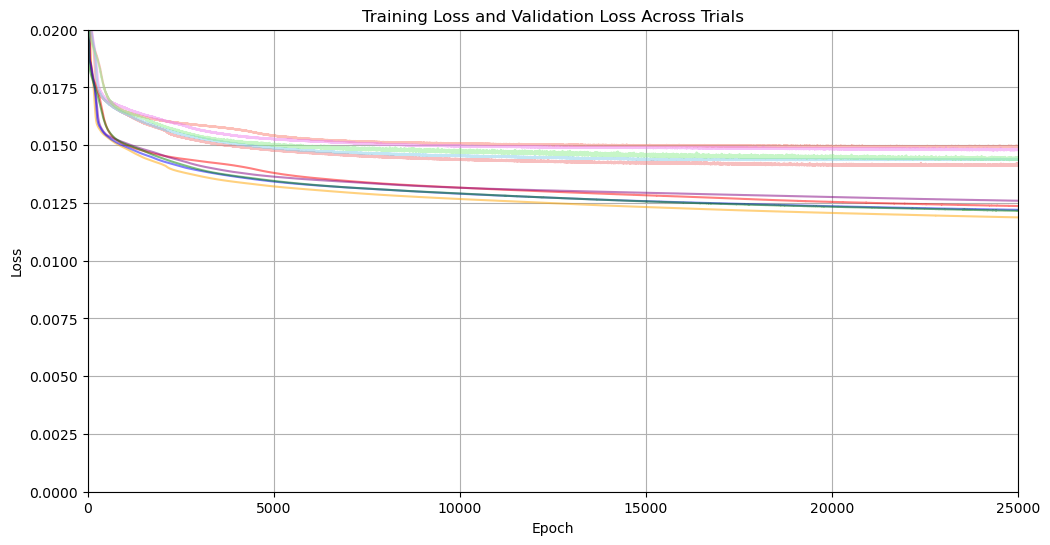

Trial 1:
  Minimum Loss: 0.011876 at Epoch 24999
  Minimum Validation Loss: 0.014097 at Epoch 23592
Trial 2:
  Minimum Loss: 0.012366 at Epoch 24984
  Minimum Validation Loss: 0.014911 at Epoch 22100
Trial 3:
  Minimum Loss: 0.012595 at Epoch 24993
  Minimum Validation Loss: 0.014769 at Epoch 24875
Trial 4:
  Minimum Loss: 0.012202 at Epoch 24997
  Minimum Validation Loss: 0.014348 at Epoch 18722
Trial 5:
  Minimum Loss: 0.012158 at Epoch 24990
  Minimum Validation Loss: 0.014347 at Epoch 24768
Average Difference Between Loss and Validation Loss (Epochs > 1000): -0.001880
Variability of Loss Across Trials (Epochs > 1000): 0.000207
Variability of Validation Loss Across Trials (Epochs > 1000): 0.000266


In [39]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the base folder where training loss data is stored
base_folder = 'AE_Grid_BS_128_LR_6/Fourth_Nodes_AE_Default_Data'
trial_colors = ['orange', 'red', 'purple', 'blue', 'green']
val_colors = ['lightcoral', 'salmon', 'violet', 'skyblue', 'lightgreen']

# Initialize lists to store global data for statistics
global_loss = []
global_val_loss = []

# Loop through each trial to collect and plot data
plt.figure(figsize=(12, 6))
for trial in range(1, 6):
    loss_data_folder = os.path.join(base_folder, f'AE_Training_{trial}/AE_Training_Loss_Data')
    all_loss = []
    all_val_loss = []
    
    # Load all training loss data for the current trial
    for counts in range(25):  # Adjust range if the number of files per trial differs
        history_file_path = os.path.join(loss_data_folder, f"{counts}_Autoencoder_Training_History.pkl")
        if os.path.exists(history_file_path):
            history = pd.read_pickle(history_file_path)
            all_loss.extend(history['loss'].tolist())
            all_val_loss.extend(history['val_loss'].tolist())
        else:
            print(f"Warning: Missing file for count {counts} in trial {trial}")
    
    # Ensure epoch indices are properly aligned with the number of epochs
    epochs = list(range(len(all_loss)))
    
    # Append to global lists for statistics
    global_loss.append(all_loss)
    global_val_loss.append(all_val_loss)
    
    # Plot loss and validation loss for the current trial
    plt.plot(epochs, all_loss, label=f'Trial {trial} Loss', color=trial_colors[trial - 1], alpha=0.5)
    plt.plot(epochs, all_val_loss, label=f'Trial {trial} Validation Loss', color=val_colors[trial - 1], alpha=0.5)

# Add plot details
plt.title('Training Loss and Validation Loss Across Trials')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0, 25000)
plt.ylim(0, 0.02)
# plt.legend()
plt.grid()
plt.show()

# Calculate and print minimum loss and validation loss for each trial
for trial in range(5):
    trial_loss = np.array(global_loss[trial])
    trial_val_loss = np.array(global_val_loss[trial])
    
    # Find minimum loss and validation loss for the trial
    min_loss = np.min(trial_loss)
    min_loss_epoch = np.argmin(trial_loss)
    min_val_loss = np.min(trial_val_loss)
    min_val_loss_epoch = np.argmin(trial_val_loss)
    
    print(f"Trial {trial + 1}:")
    print(f"  Minimum Loss: {min_loss:.6f} at Epoch {min_loss_epoch}")
    print(f"  Minimum Validation Loss: {min_val_loss:.6f} at Epoch {min_val_loss_epoch}")

# Calculate average difference between loss and validation loss (ignoring first 1000 epochs)
avg_loss_val_loss_diff = np.mean([
    np.mean(np.array(global_loss[i][1000:]) - np.array(global_val_loss[i][1000:])) 
    for i in range(5)
])
print(f"Average Difference Between Loss and Validation Loss (Epochs > 1000): {avg_loss_val_loss_diff:.6f}")

# Calculate variability of loss and validation loss across trials (ignoring first 1000 epochs)
loss_variability = np.mean([
    np.std([global_loss[i][epoch] for i in range(5)]) 
    for epoch in range(1000, len(global_loss[0]))
])
val_loss_variability = np.mean([
    np.std([global_val_loss[i][epoch] for i in range(5)]) 
    for epoch in range(1000, len(global_val_loss[0]))
])

print(f"Variability of Loss Across Trials (Epochs > 1000): {loss_variability:.6f}")
print(f"Variability of Validation Loss Across Trials (Epochs > 1000): {val_loss_variability:.6f}")